In [89]:
!pip install notebook --upgrade
import pickle
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

Requirement already up-to-date: notebook in /Users/Samrin/anaconda3/lib/python3.7/site-packages (6.0.2)


#### Text pre-processing

In [70]:
data=pd.read_pickle('Data/Pickle/16k_apperal_data')
# NLTK download stop words. [RUN ONLY ONCE]
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

In [59]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string
    

list of stop words: {"you'll", "you'd", "that'll", 'all', 'they', 'ours', 'during', 'your', 'will', "you're", 'of', 'y', 'his', 'hasn', 'further', "wouldn't", 'be', 'own', 'm', 'himself', "she's", 'in', 'so', 're', "mustn't", 'you', 'had', 'themselves', 'the', 'been', 'my', 'are', 'against', 'into', 'nor', 'weren', 'those', 'yours', 'won', "wasn't", 'on', 'hadn', 'as', 'who', "it's", 'theirs', 'down', 'than', 'wasn', 'here', 'mustn', 'then', 'them', 'he', 'just', 'does', 'from', 'haven', 'him', 'she', 'yourselves', 'what', 'because', 'after', "shan't", 'hers', 'isn', 'if', 'by', 'that', 'and', 'why', 'some', "doesn't", "weren't", 'about', 'is', 'any', 'couldn', "didn't", 'between', 'myself', 'over', 'at', 'were', 'shan', 'these', 'or', 'each', 'this', 'more', 'such', "don't", 'not', 'me', "needn't", 'off', 'a', 'ain', "aren't", 'an', 'before', 'ma', 'its', 'doing', 'having', 'am', 't', "shouldn't", 'out', 'how', 'we', 'very', "won't", 'yourself', 'don', 'while', 'their', 'didn', 'would

In [60]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

10.04848800000002 seconds


In [61]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
43    featherlite ladies silky smooth pique white xl           $13.53

#### Text based product similarity

In [71]:
data.to_pickle('Data/Pickle/16k_apperal_data_preprocessed')

In [72]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
43  B0079BMKDS                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
43  https://images-na.ssl-images-amazon.com/images...           APPAREL   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
27  Supernatural Chibis Sam Dean And Castiel O Nec...           $7.39  
43  Featherlite Ladies' Silky Smooth Pique (White)...          $13.53

In [73]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

#### Bag of Words (BoW) on product titles.

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

(17593, 11360)

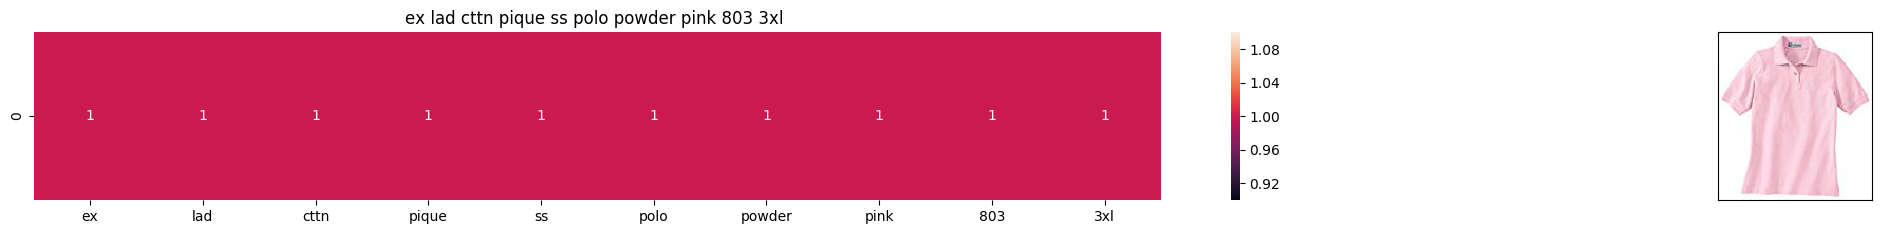

ASIN : B00ELC644O
Brand: Ash City
Title: ex lad cttn pique ss polo powder pink 803 3xl 
Euclidean similarity with the query image : 0.0


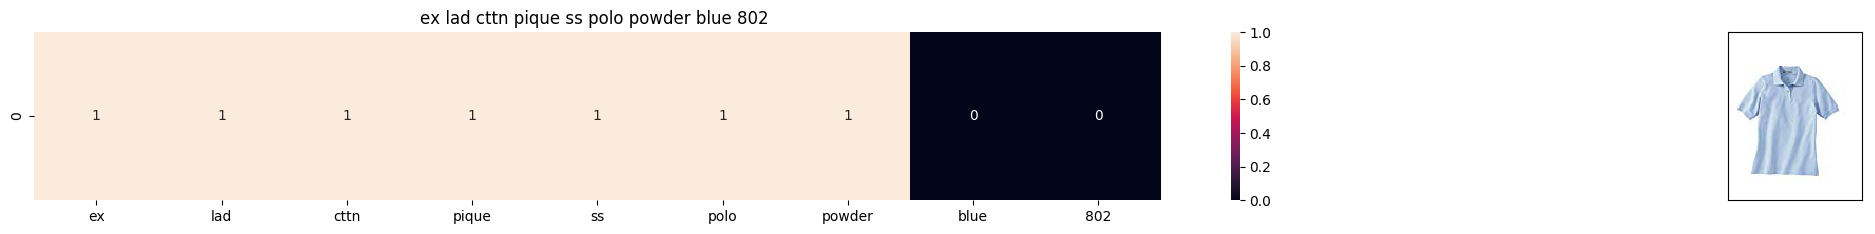

ASIN : B00ELC5OC2
Brand: Ash City
Title: ex lad cttn pique ss polo powder blue 802 
Euclidean similarity with the query image : 2.23606797749979


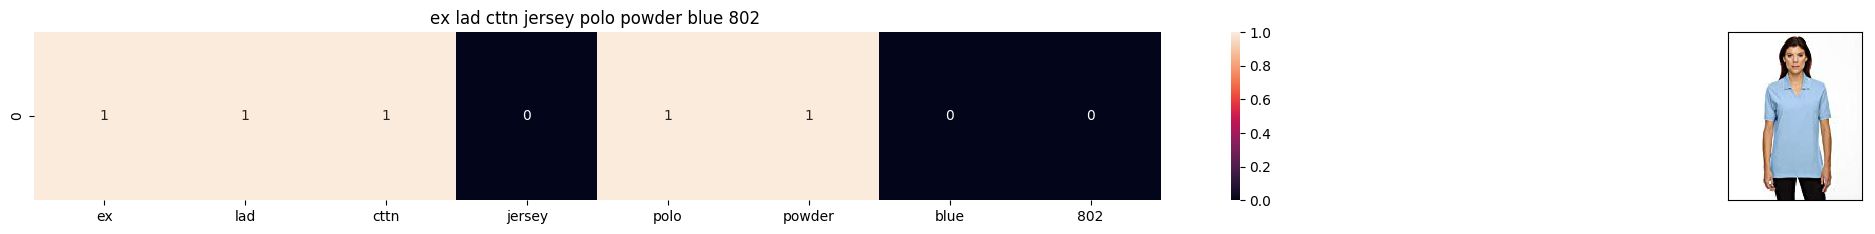

ASIN : B00ELCAEEU
Brand: Ash City
Title: ex lad cttn jersey polo powder blue 802 
Euclidean similarity with the query image : 2.8284271247461903


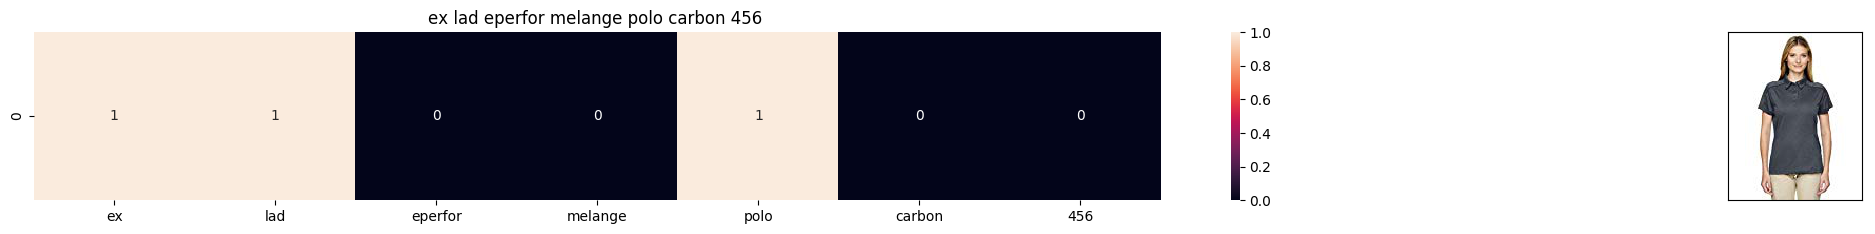

ASIN : B00JV3NO9Q
Brand: Ash City
Title: ex lad eperfor melange polo carbon 456 
Euclidean similarity with the query image : 3.3166247903554


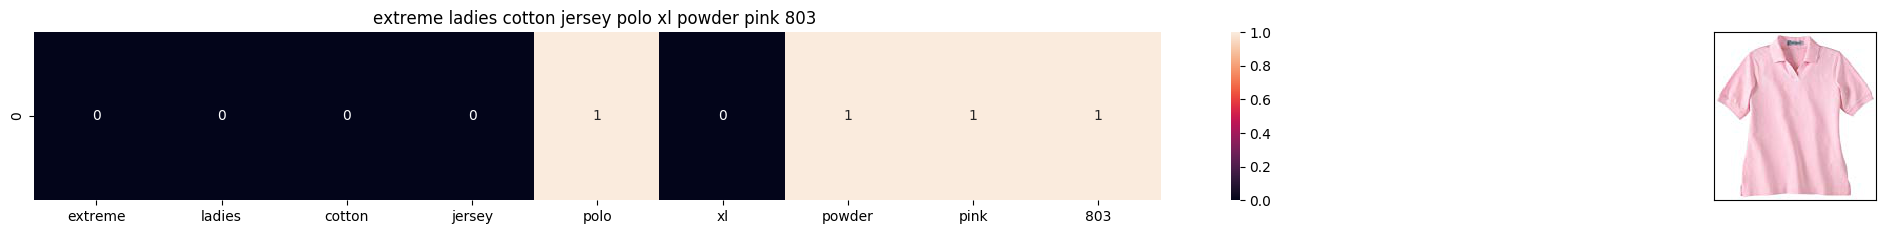

ASIN : B014WC6TTW
Brand: Ash City - Extreme
Title: extreme ladies cotton jersey polo xl powder pink 803 
Euclidean similarity with the query image : 3.3166247903554


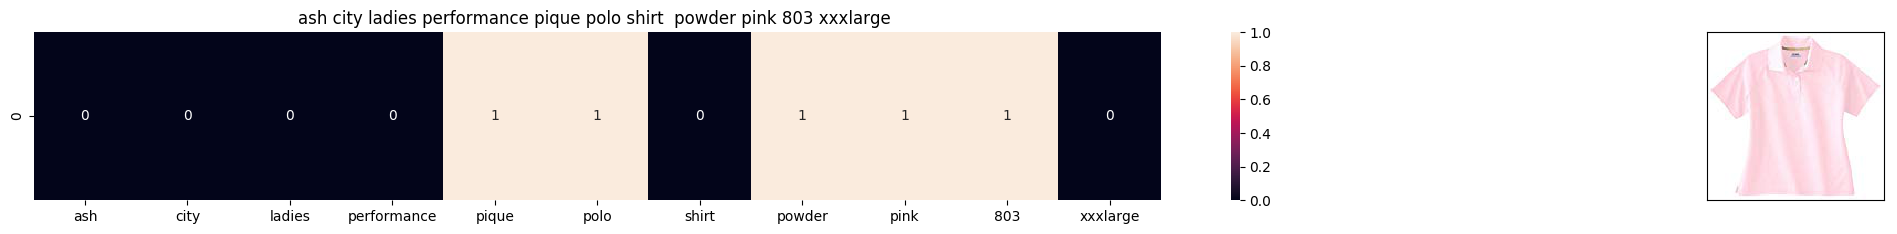

ASIN : B01GESY7FU
Brand: Ash City - Extreme
Title: ash city ladies performance pique polo shirt  powder pink 803 xxxlarge 
Euclidean similarity with the query image : 3.3166247903554


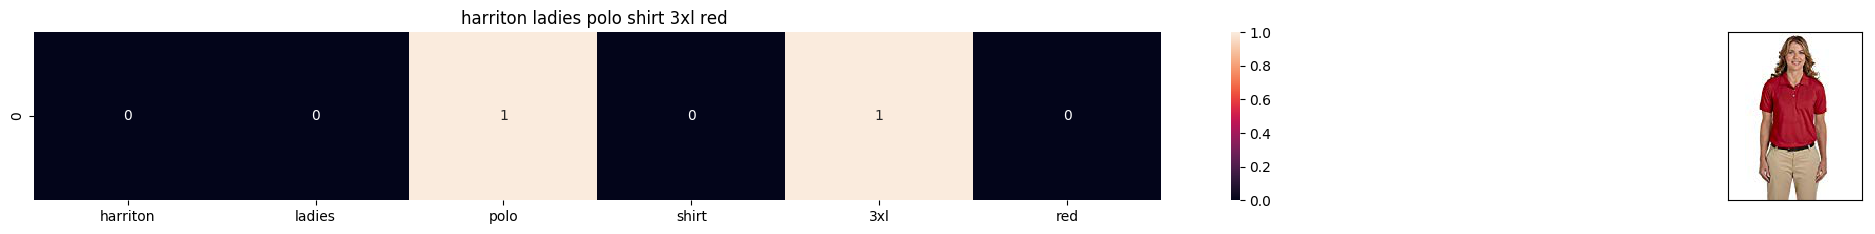

ASIN : B00B27UYCE
Brand: Harriton
Title: harriton ladies polo shirt 3xl red 
Euclidean similarity with the query image : 3.4641016151377544


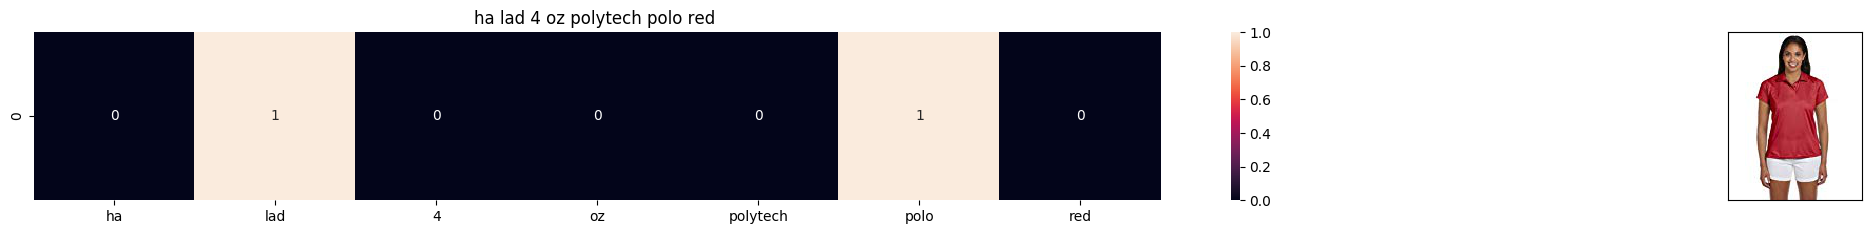

ASIN : B006HT3NT8
Brand: Harriton
Title: ha lad 4 oz polytech polo red 
Euclidean similarity with the query image : 3.4641016151377544


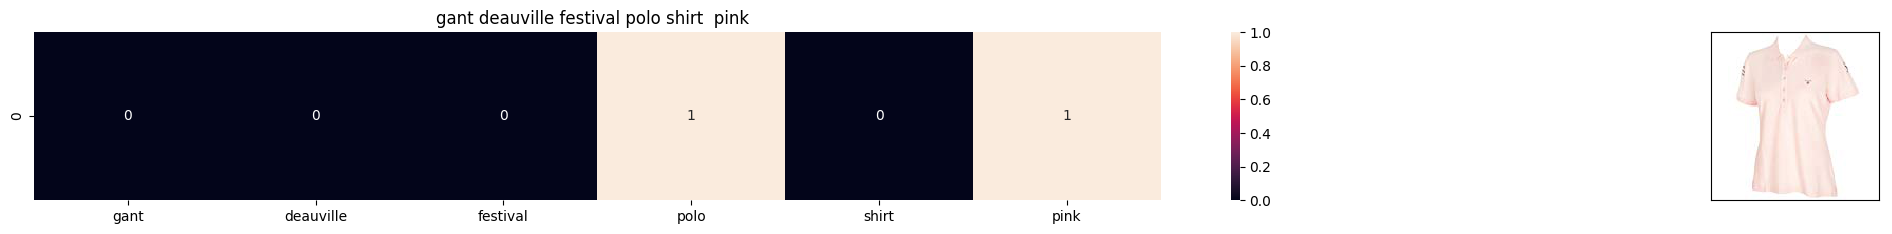

ASIN : B073SN3XGP
Brand: GANT
Title: gant deauville festival polo shirt  pink  
Euclidean similarity with the query image : 3.4641016151377544


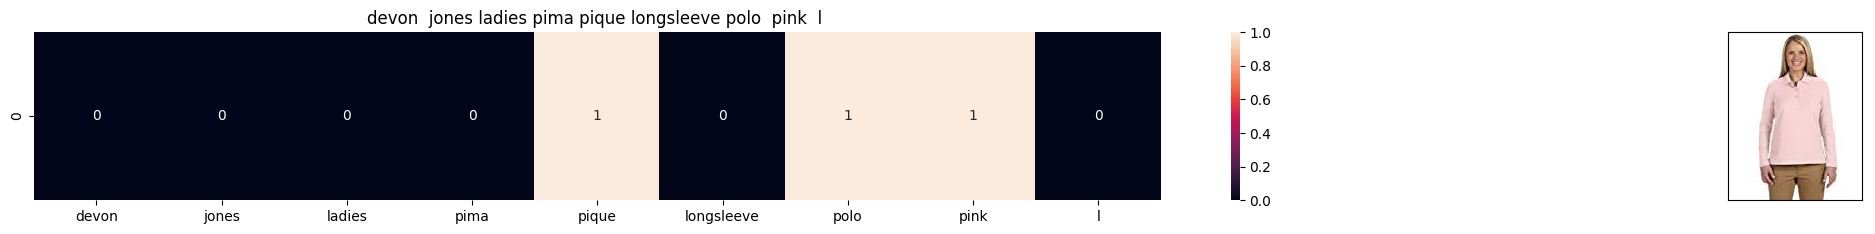

ASIN : B00MX0X2MI
Brand: Devon & Jones
Title: devon  jones ladies pima pique longsleeve polo  pink  l 
Euclidean similarity with the query image : 3.4641016151377544


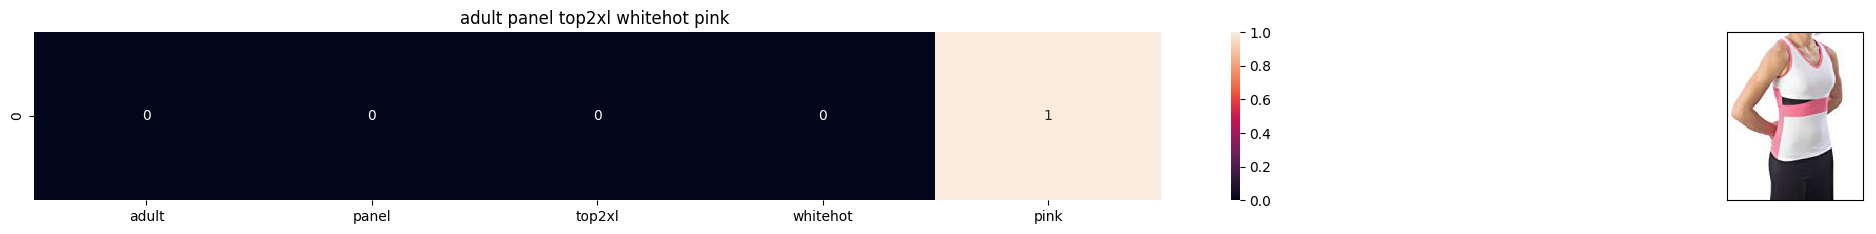

ASIN : B00C0A2IF8
Brand: Pizzazz
Title: adult panel top2xl whitehot pink 
Euclidean similarity with the query image : 3.605551275463989


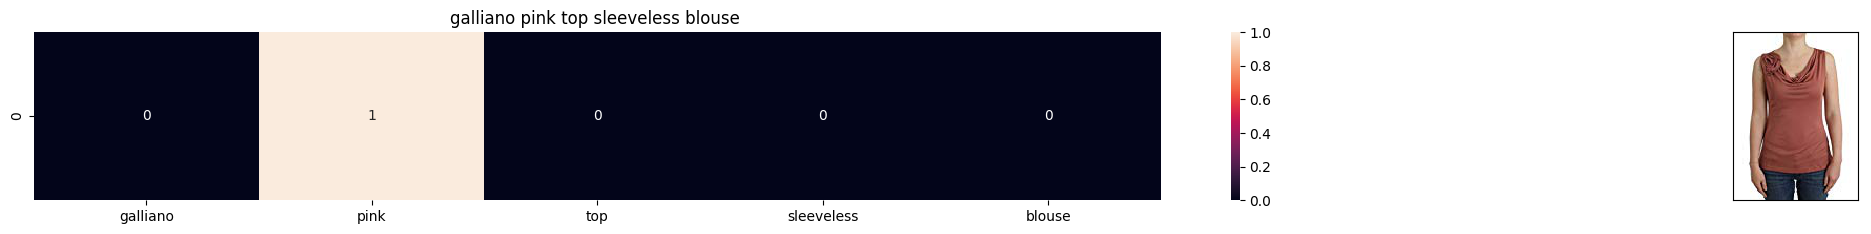

ASIN : B074G4M6D1
Brand: Galliano
Title: galliano pink top sleeveless blouse 
Euclidean similarity with the query image : 3.605551275463989


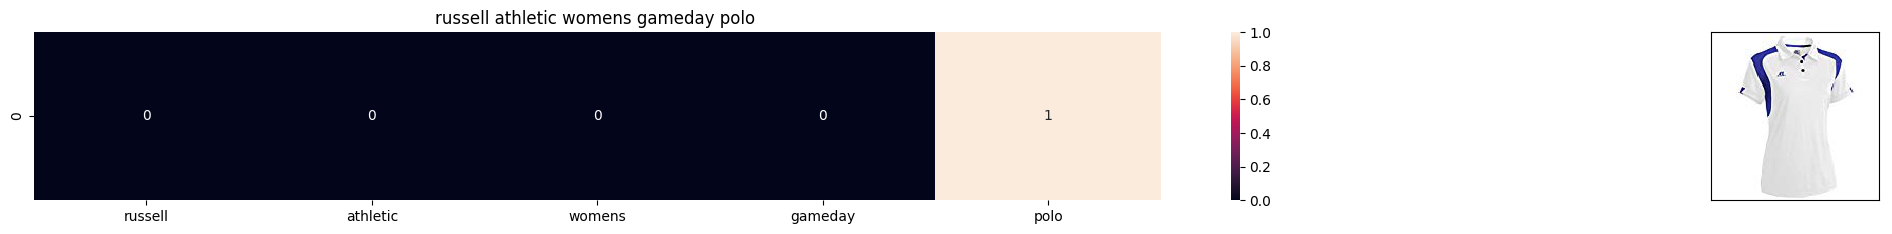

ASIN : B00DUXYG0O
Brand: Russell Athletic
Title: russell athletic womens gameday polo 
Euclidean similarity with the query image : 3.605551275463989


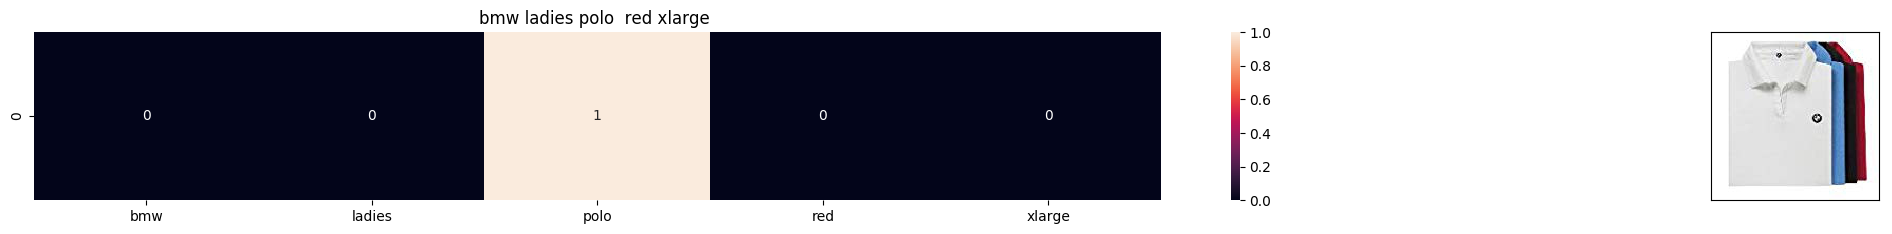

ASIN : B008R82LNQ
Brand: None
Title: bmw ladies polo  red xlarge 
Euclidean similarity with the query image : 3.605551275463989


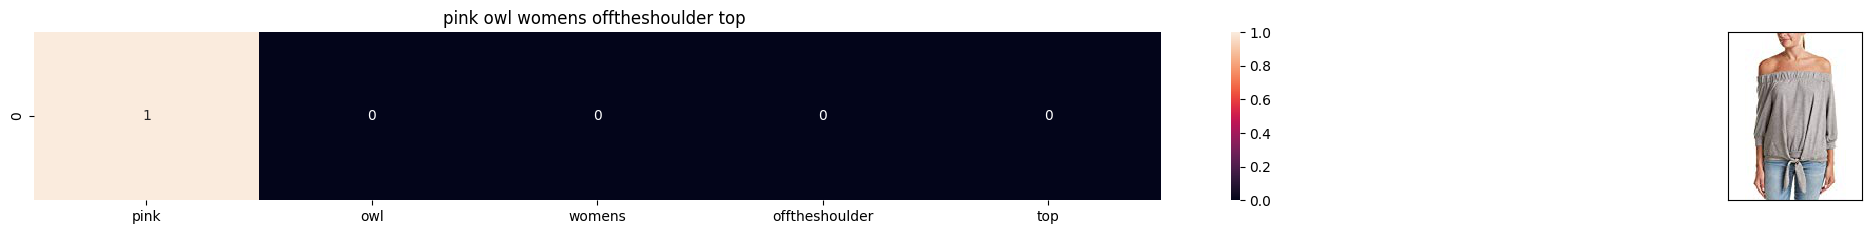

ASIN : B0742L2CC1
Brand: PinkOwl
Title: pink owl womens offtheshoulder top 
Euclidean similarity with the query image : 3.605551275463989


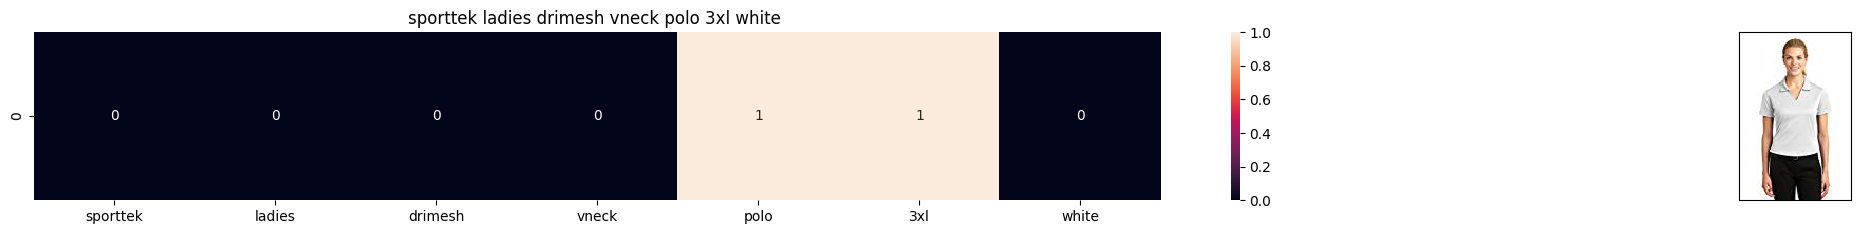

ASIN : B008PVBYWY
Brand: Sport-Tek
Title: sporttek ladies drimesh vneck polo 3xl white 
Euclidean similarity with the query image : 3.605551275463989


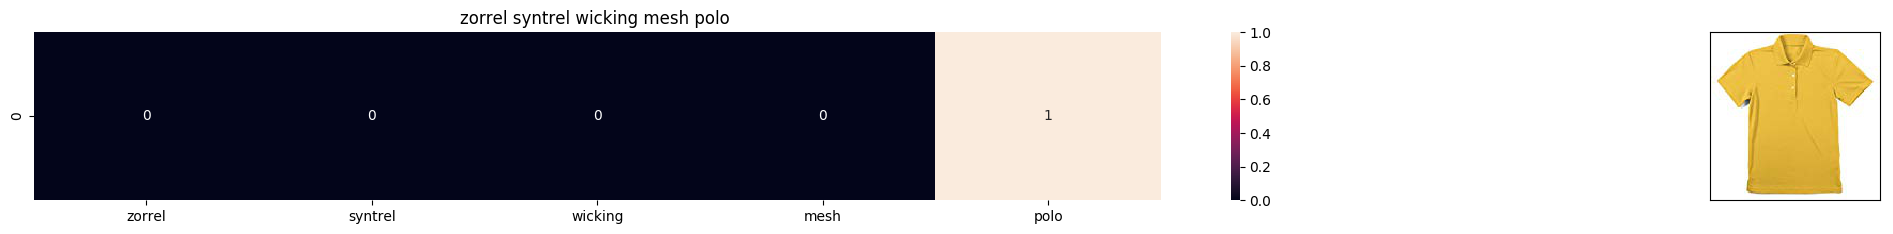

ASIN : B008DJH382
Brand: Zorrel
Title: zorrel syntrel wicking mesh polo 
Euclidean similarity with the query image : 3.605551275463989


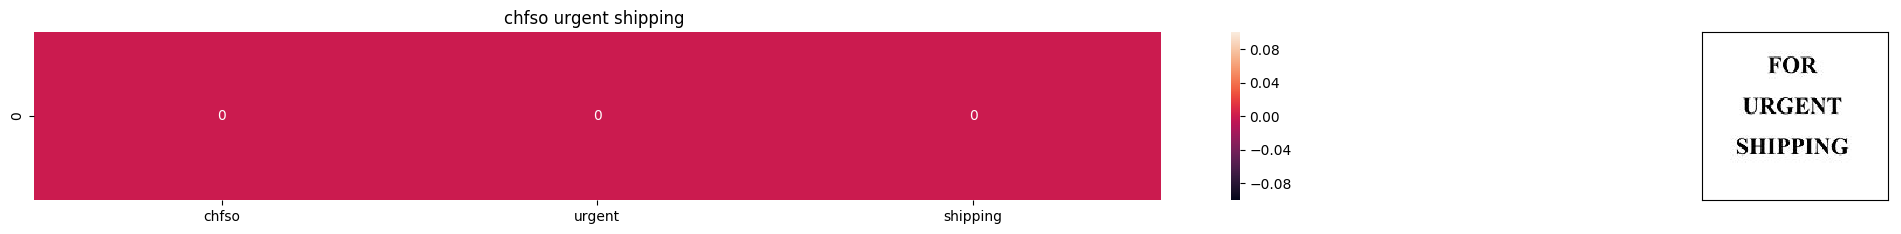

ASIN : B017JSX9OO
Brand: CHFSO
Title: chfso urgent shipping 
Euclidean similarity with the query image : 3.605551275463989


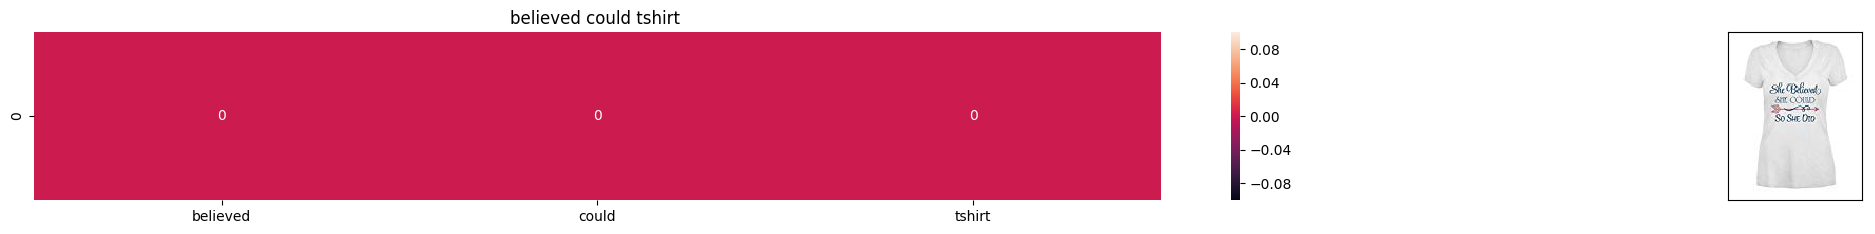

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.605551275463989


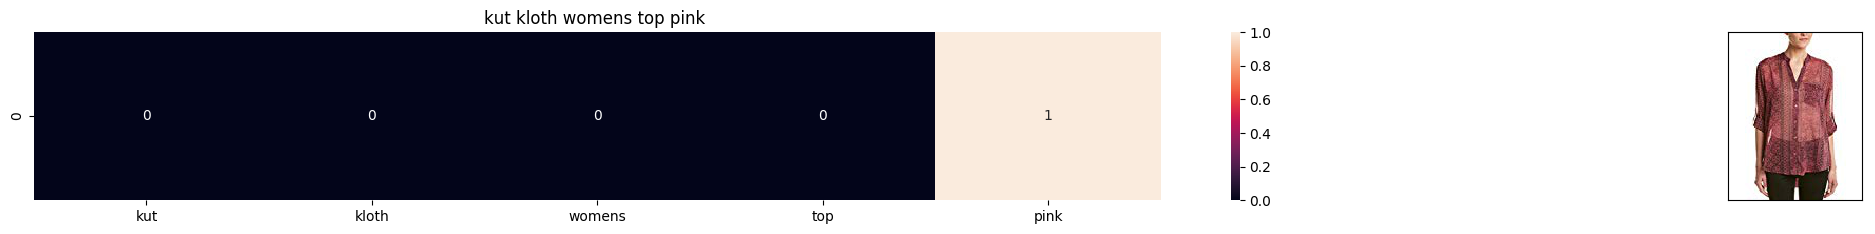

ASIN : B06XTY5HB6
Brand: KUT from the Kloth
Title: kut kloth womens top pink 
Euclidean similarity with the query image : 3.605551275463989


'B06XTY5HB6'

In [66]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    return data['asin'].loc[df_indices[i]]

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(1152, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

#### TF-IDF based product similarity

In [18]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

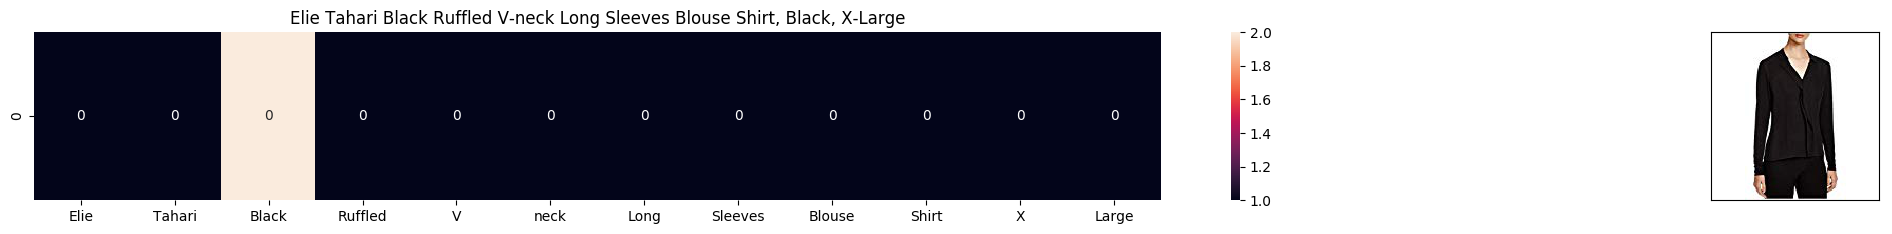

ASIN : B0728DT431
BRAND : Elie Tahari
Eucliden distance from the given image : 0.0


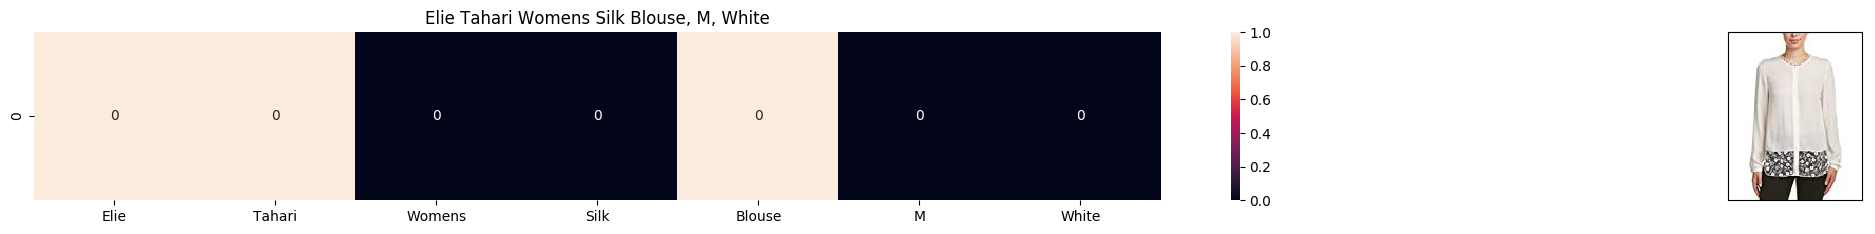

ASIN : B0758ZBV4G
BRAND : Elie Tahari
Eucliden distance from the given image : 0.930818338718771


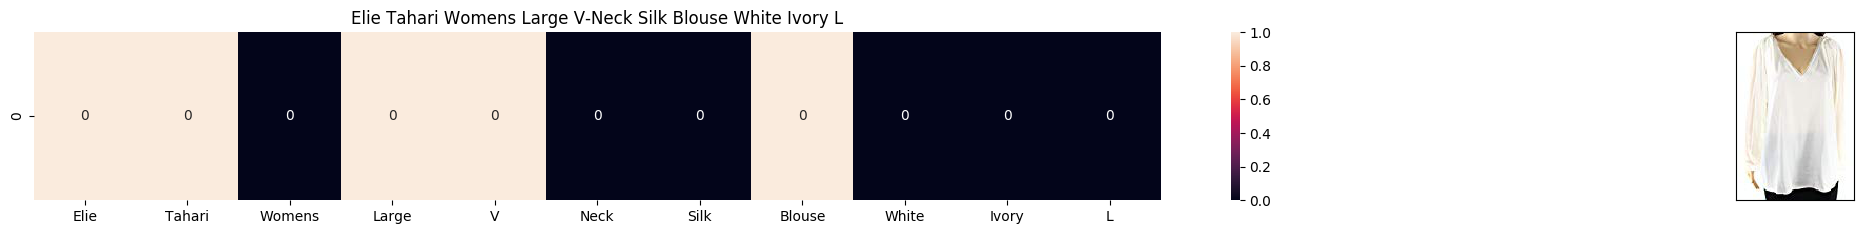

ASIN : B0758L371D
BRAND : Elie Tahari
Eucliden distance from the given image : 0.946967152190245


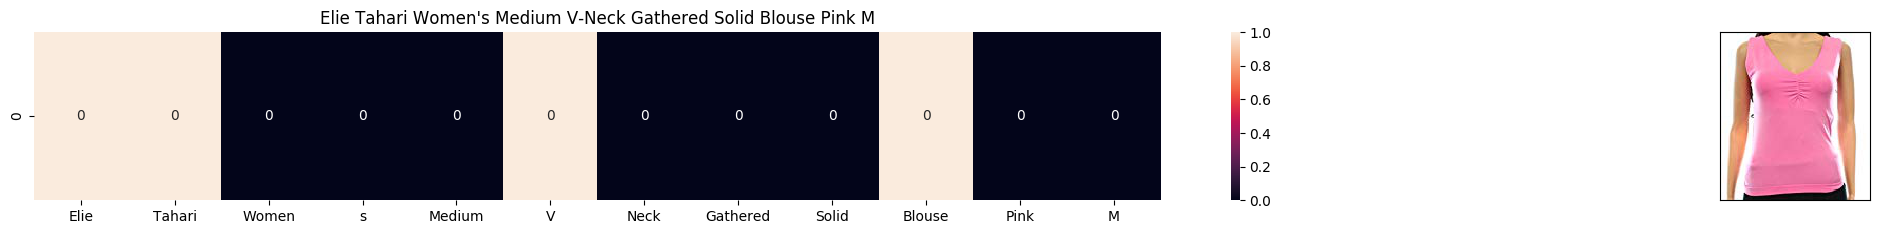

ASIN : B072VH8MKT
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9917066516089336


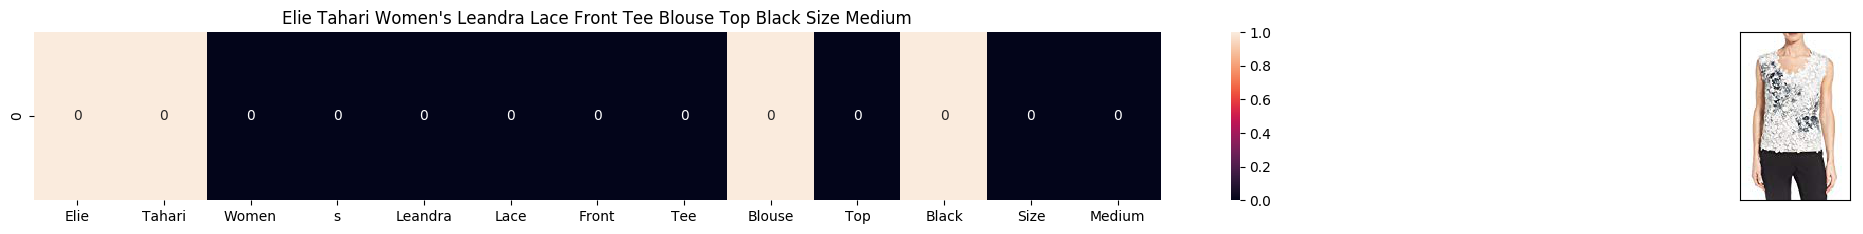

ASIN : B072HMB95W
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0506076854072617


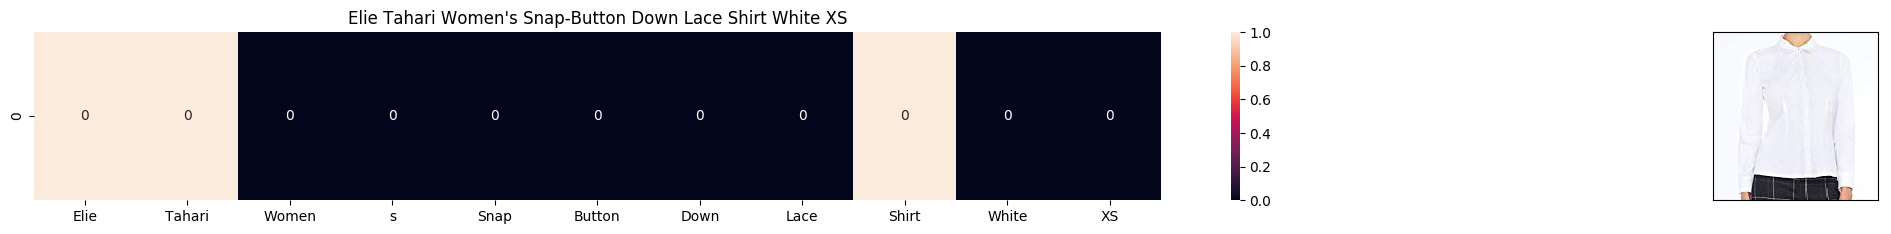

ASIN : B06X8YS632
BRAND : Elie Tahari
Eucliden distance from the given image : 1.066566411352814


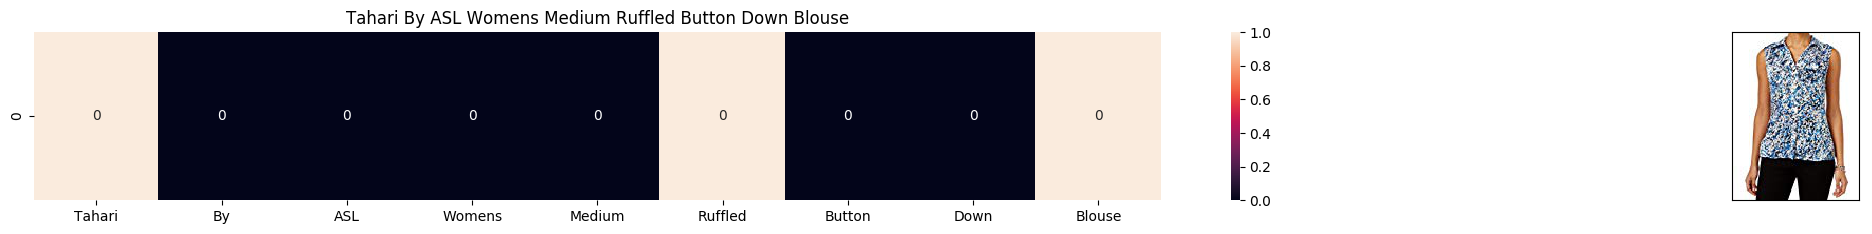

ASIN : B0727R3ZK8
BRAND : Tahari ASL
Eucliden distance from the given image : 1.0709334130469317


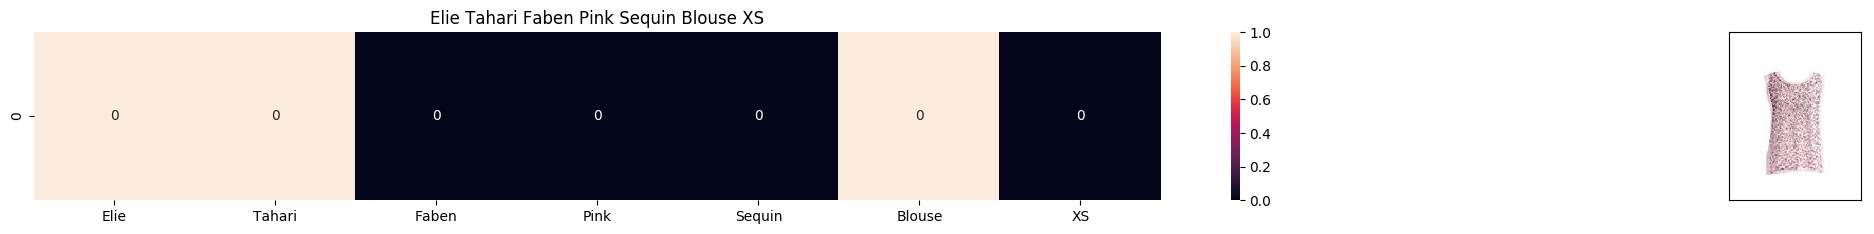

ASIN : B074VCVG5V
BRAND : Elie Tahari
Eucliden distance from the given image : 1.08545446199004


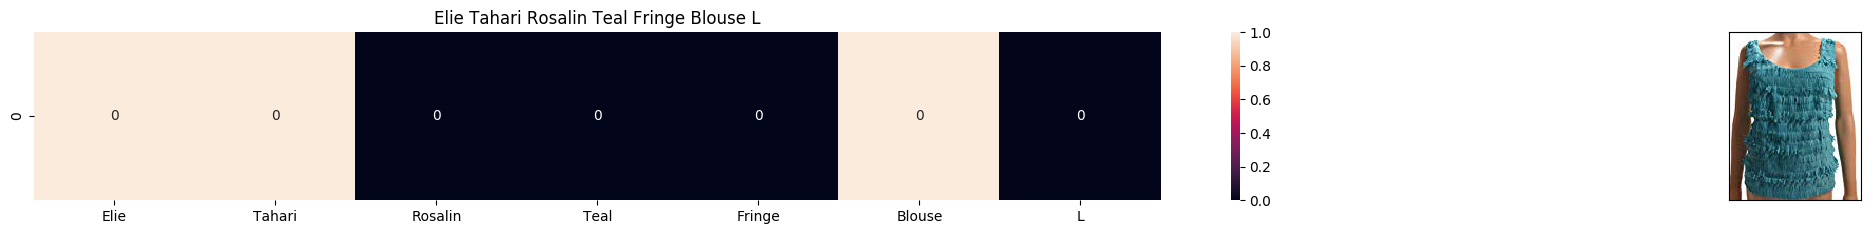

ASIN : B0751J7MJ5
BRAND : Elie Tahari
Eucliden distance from the given image : 1.092029162906729


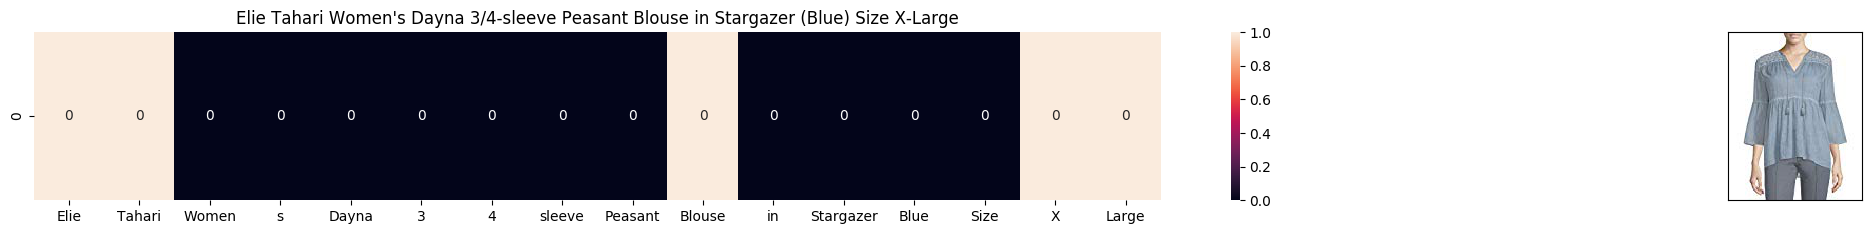

ASIN : B07258KQPD
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0977009126384472


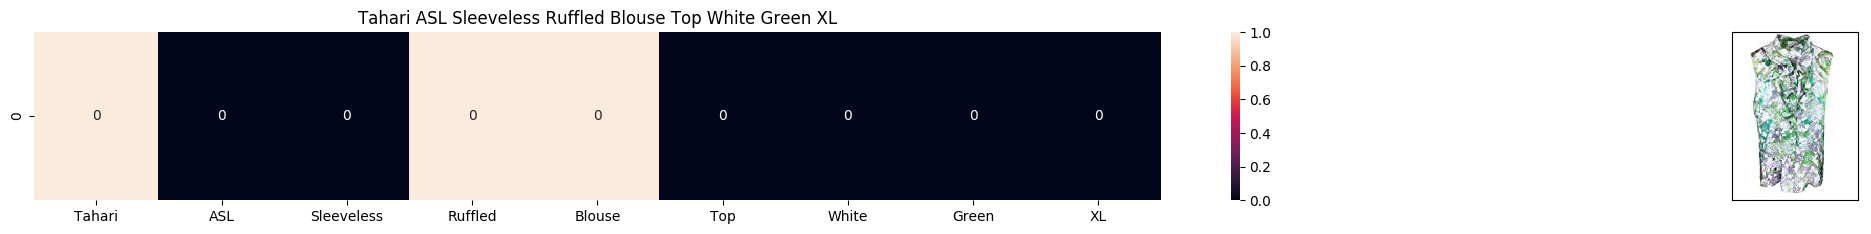

ASIN : B07196K8ZK
BRAND : Tahari ASL
Eucliden distance from the given image : 1.0978263376268496


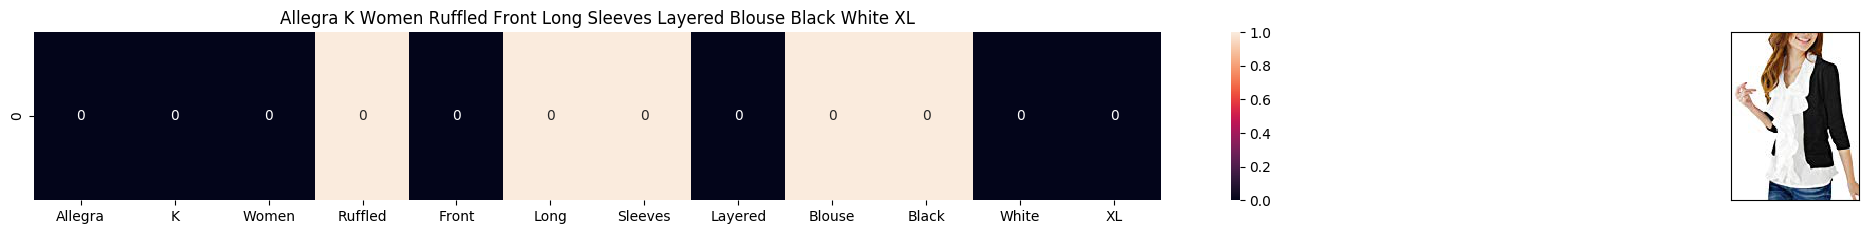

ASIN : B00E1LCYZI
BRAND : Allegra K
Eucliden distance from the given image : 1.1093679744838518


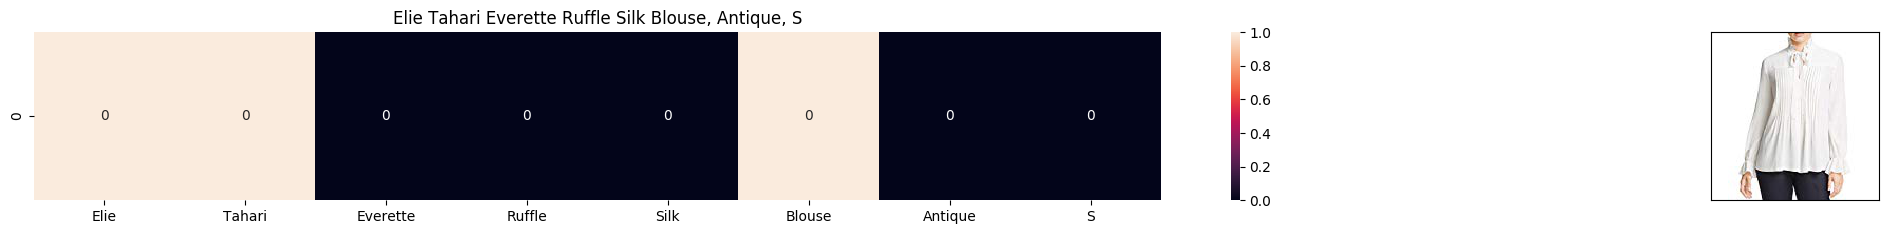

ASIN : B06XQS7B2H
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1158494288000618


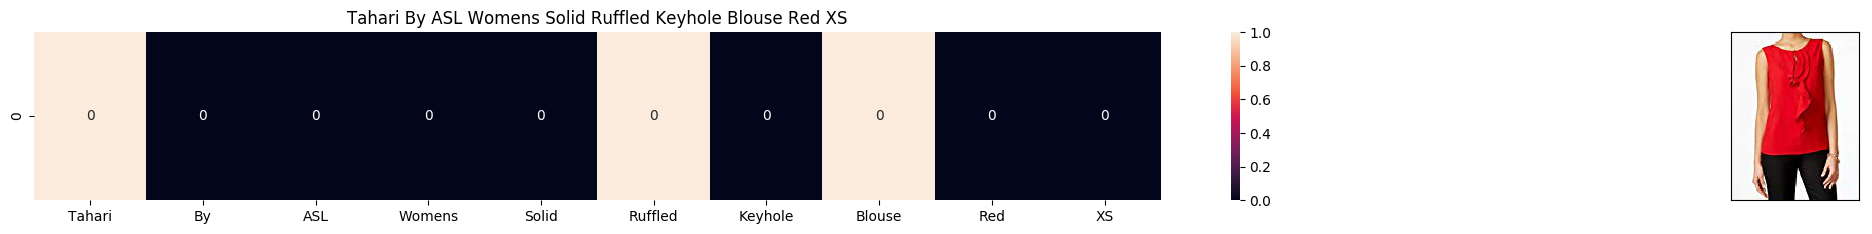

ASIN : B073DRMT4F
BRAND : Tahari ASL
Eucliden distance from the given image : 1.12308897039674


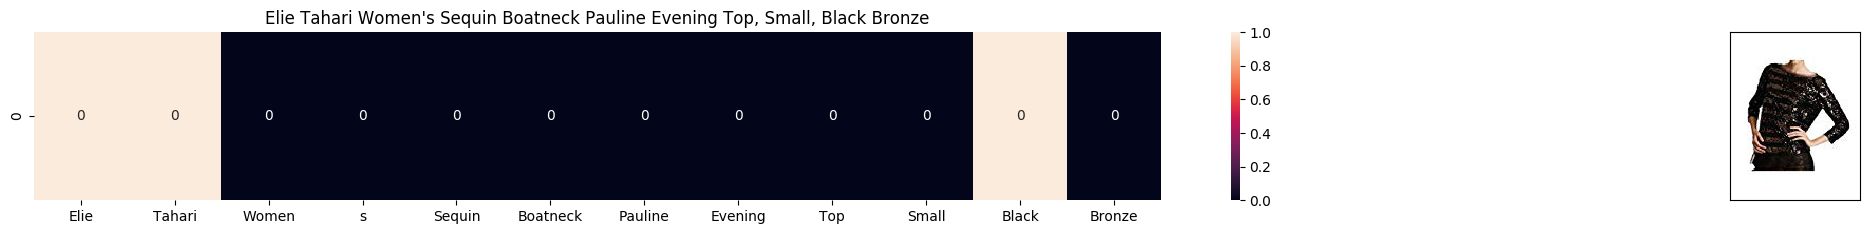

ASIN : B005E2L4XG
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1459082030786756


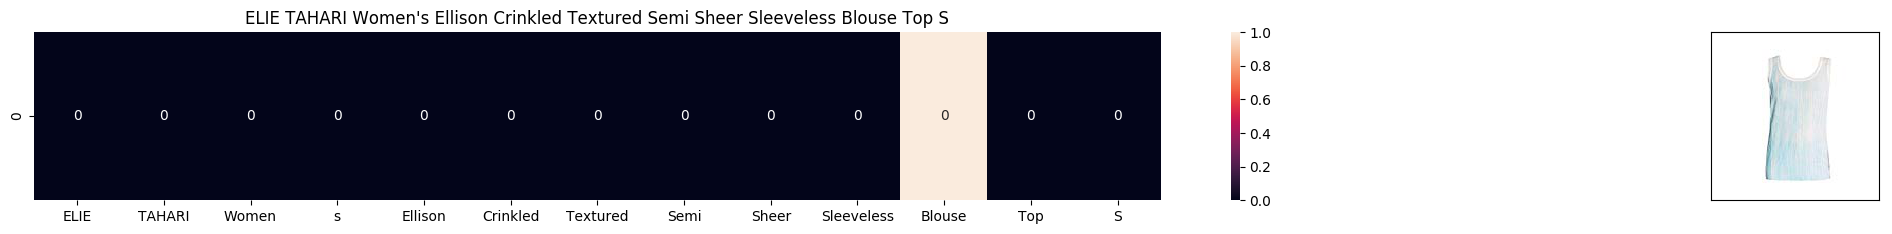

ASIN : B074VBLW5S
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1581769909433588


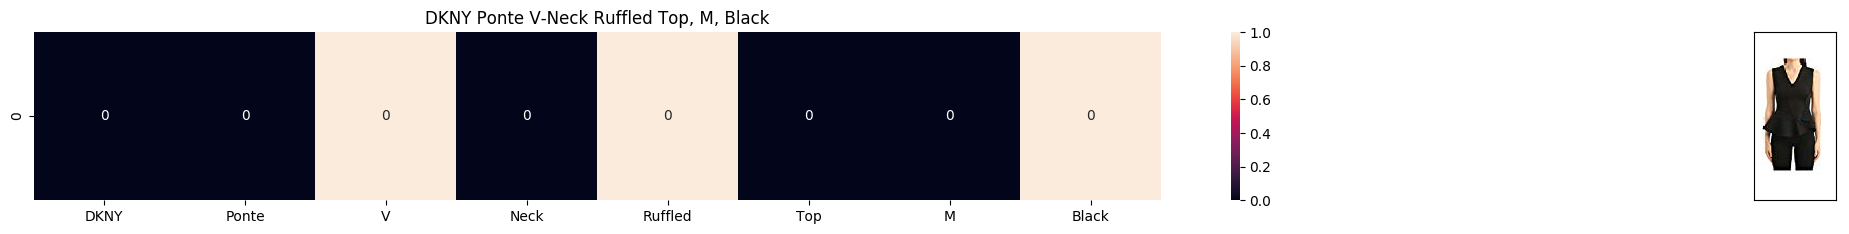

ASIN : B06XH7HQ2T
BRAND : DKNY
Eucliden distance from the given image : 1.1592903335734797


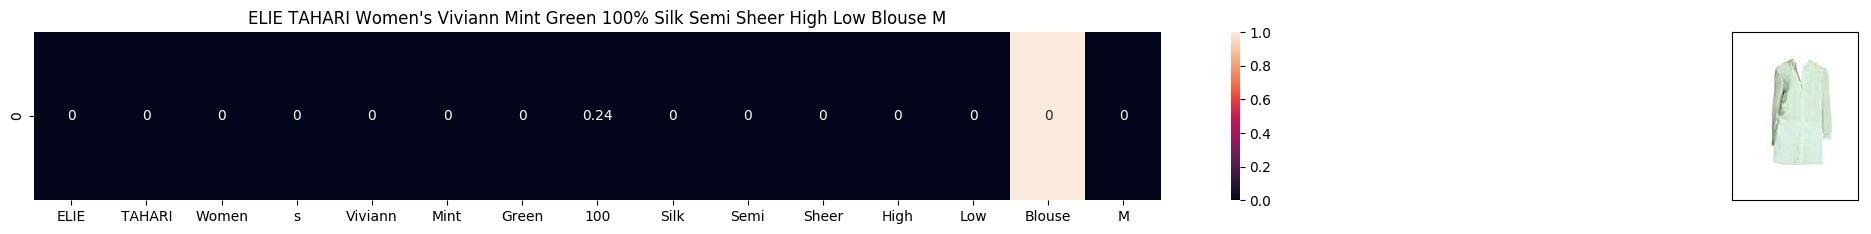

ASIN : B074VBRNX8
BRAND : Elie Tahari
Eucliden distance from the given image : 1.1758332562415978


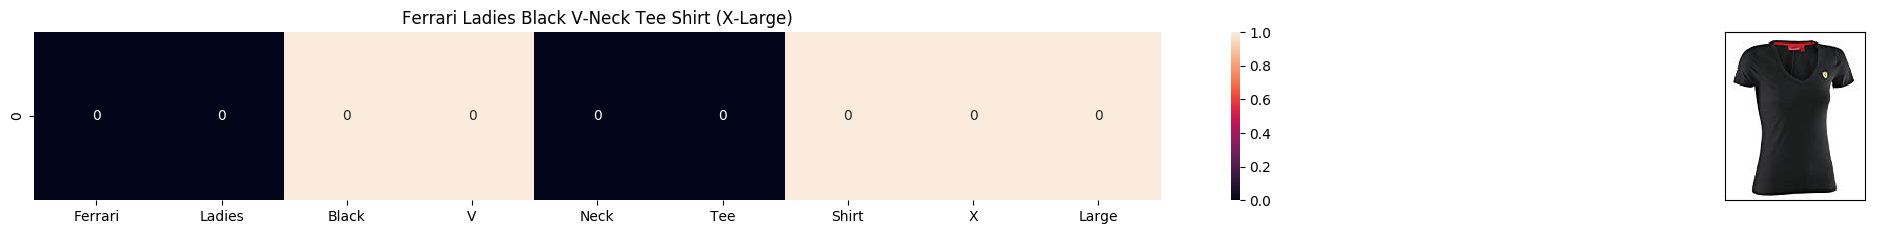

ASIN : B01EZ6XKR4
BRAND : Ferrari
Eucliden distance from the given image : 1.1773106599940453


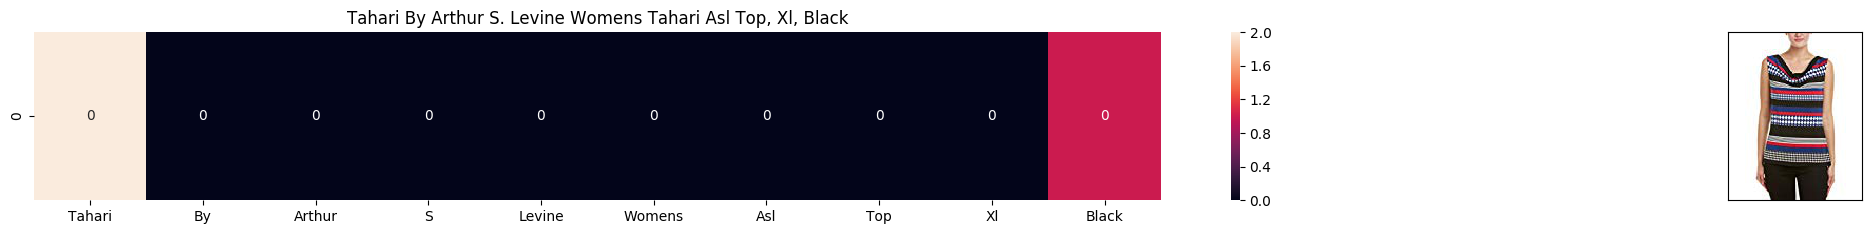

ASIN : B06X1BSY2V
BRAND : Tahari by Arthur S. Levine
Eucliden distance from the given image : 1.1849129271513121


In [75]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

#### IDF based product similarity

In [76]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [77]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))


In [78]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

ZeroDivisionError: division by zero

In [23]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)


#### In the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title


#### Lets get similar products for product ID 1152 and 104 using IDF


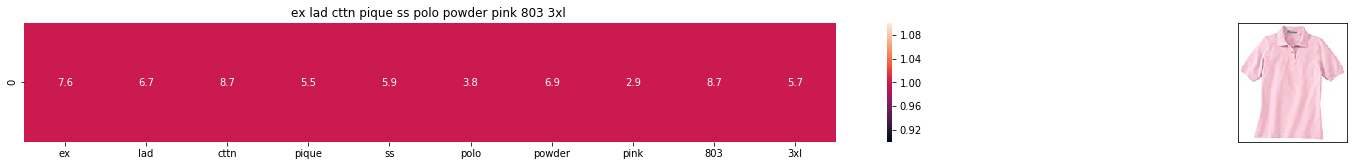

ASIN : B00ELC644O
Brand : Ash City
euclidean distance from the given image : 0.0


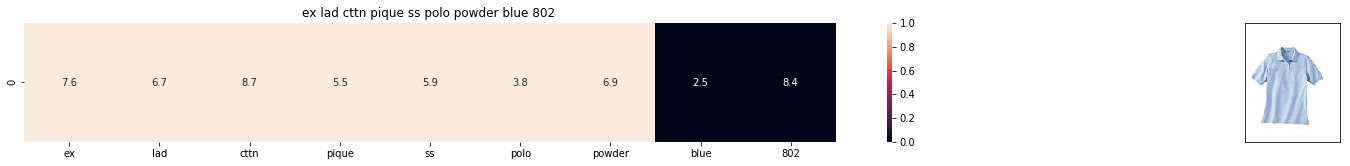

ASIN : B00ELC5OC2
Brand : Ash City
euclidean distance from the given image : 13.892433565307993


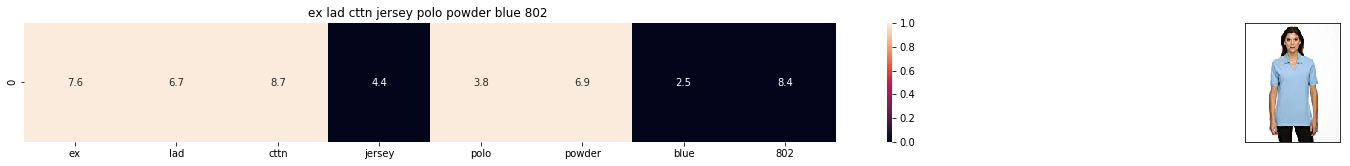

ASIN : B00ELCAEEU
Brand : Ash City
euclidean distance from the given image : 16.66422926154484


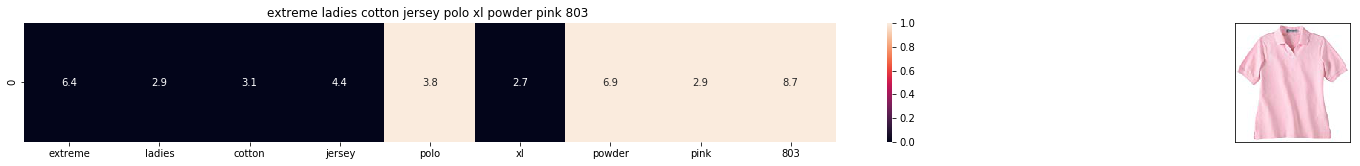

ASIN : B014WC6TTW
Brand : Ash City - Extreme
euclidean distance from the given image : 19.04053227244611


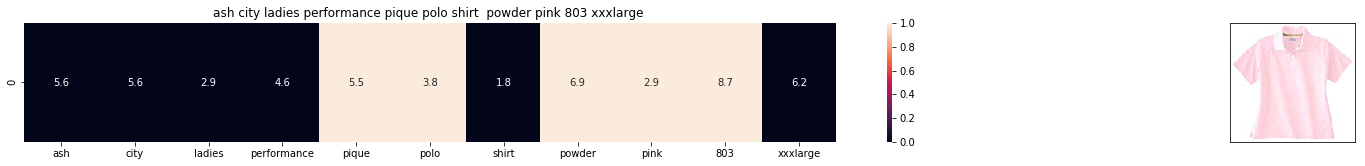

ASIN : B01GESY7FU
Brand : Ash City - Extreme
euclidean distance from the given image : 19.508790912338053


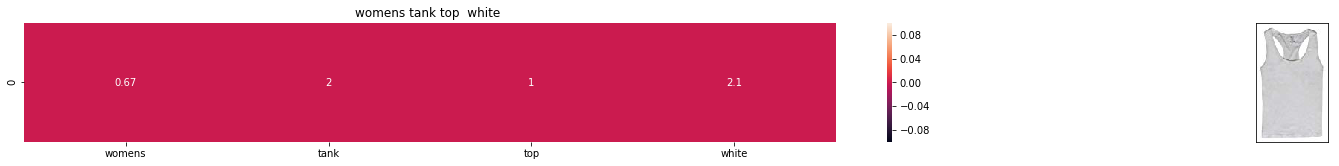

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 20.787163124709057


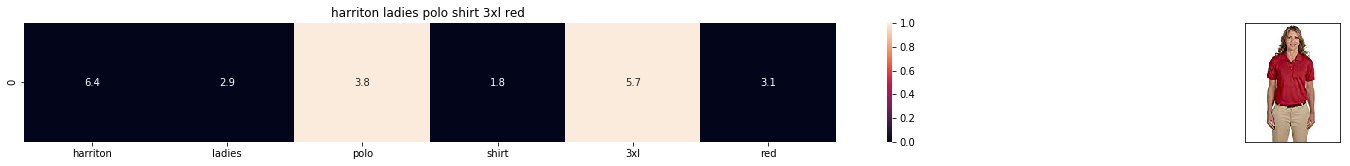

ASIN : B00B27UYCE
Brand : Harriton
euclidean distance from the given image : 20.919916965476602


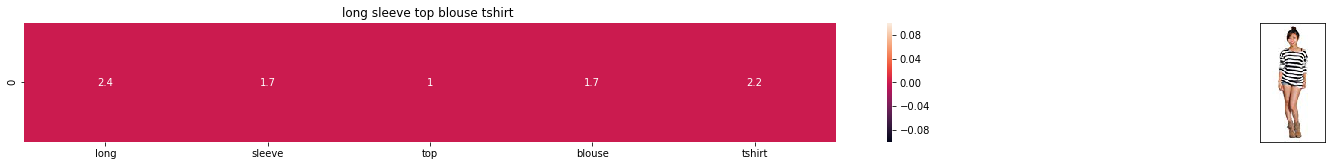

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 20.96872984638217


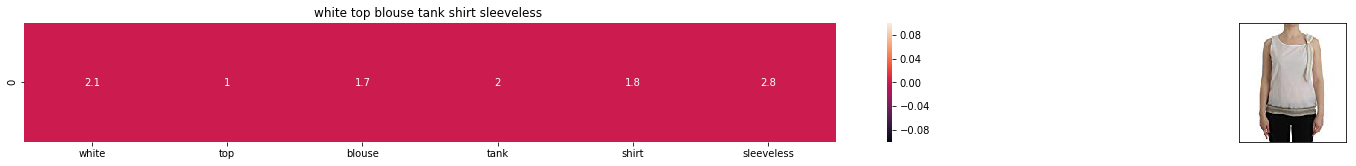

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 21.108144389394354


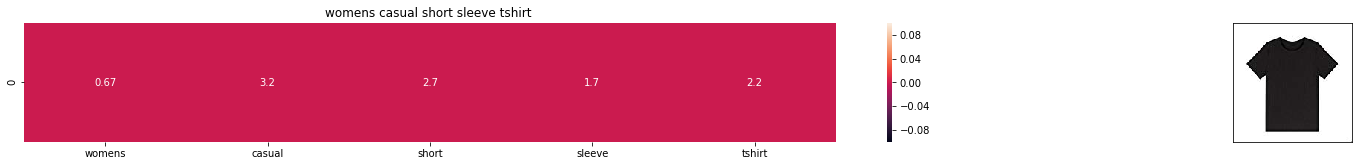

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 21.166618104128375


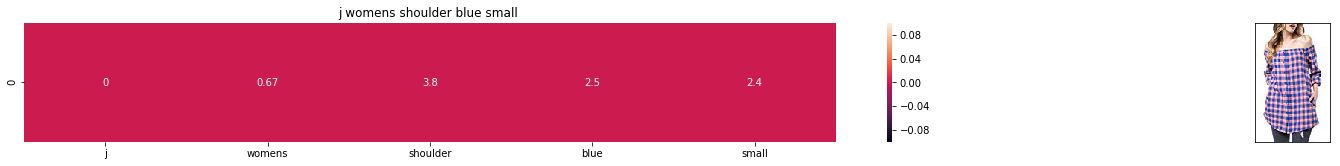

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 21.19783403739974


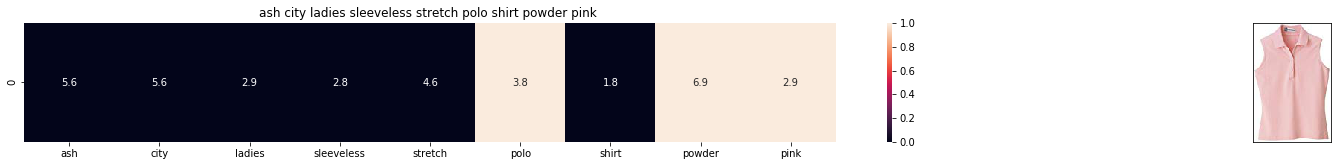

ASIN : B002KG40KS
Brand : Ash City
euclidean distance from the given image : 21.317044966989098


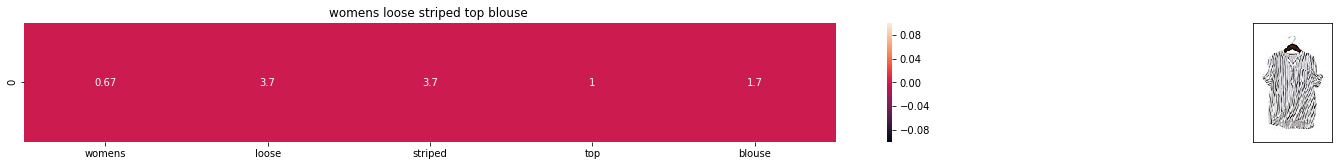

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 21.323185818991636


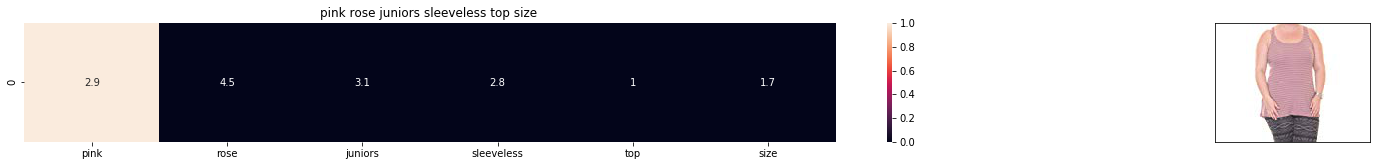

ASIN : B01MG5KJCQ
Brand : PINK ROSE
euclidean distance from the given image : 21.355081690212433


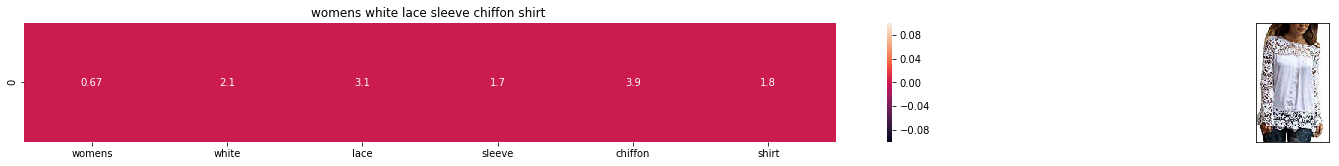

ASIN : B073JWSM1V
Brand : Fuming
euclidean distance from the given image : 21.40287485590933


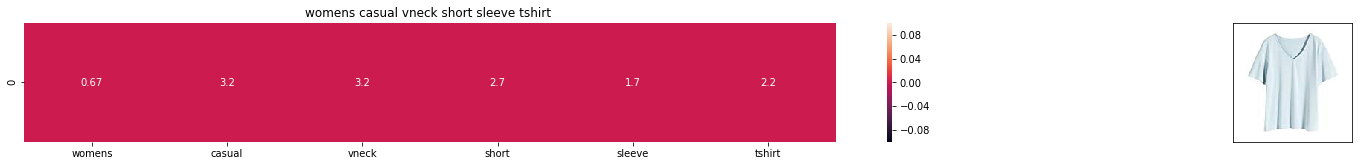

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 21.41337978361968


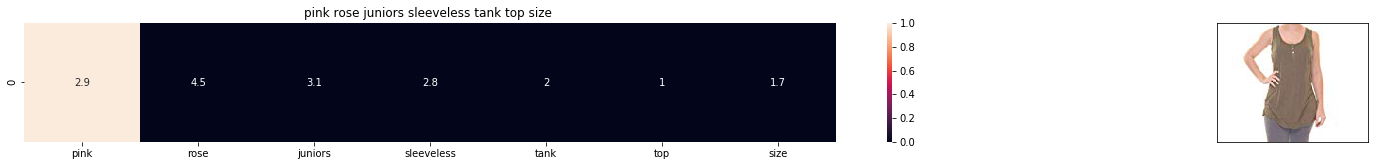

ASIN : B06XWXZJ45
Brand : PINK ROSE
euclidean distance from the given image : 21.445997666288363


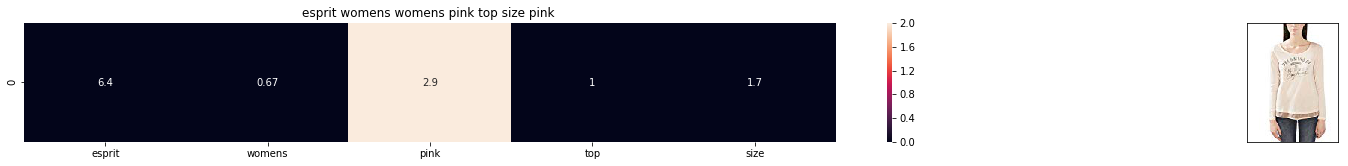

ASIN : B01N408GQ0
Brand : Esprit
euclidean distance from the given image : 21.452002468411415


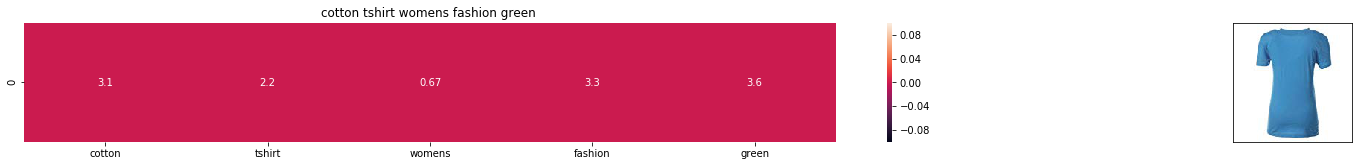

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 21.47655205885817


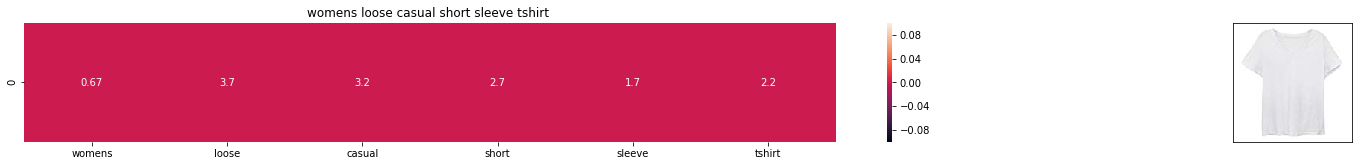

ASIN : B07567M2M9
Brand : Sunshine
euclidean distance from the given image : 21.494040383398012


In [24]:
idf_model(1152,20)

#### Text Semantics based product similarity

In [79]:
# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
!pip install -U gensim

Requirement already up-to-date: gensim in /Users/Samrin/anaconda3/lib/python3.7/site-packages (3.8.1)


In [80]:
#https://groups.google.com/forum/#!topic/gensim/RQ7If14yWbk# Custom Word2Vec using your own text data.
#https://github.com/RaRe-Technologies/gensim-data/releases/tag/word2vec-google-news-300
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''

'\n# Set values for various parameters\nnum_features = 300    # Word vector dimensionality                      \nmin_word_count = 1    # Minimum word count                        \nnum_workers = 4       # Number of threads to run in parallel\ncontext = 10          # Context window size                                                                                    \ndownsampling = 1e-3   # Downsample setting for frequent words\n\n# Initialize and train the model (this will take some time)\nfrom gensim.models import word2vec\nprint ("Training model...")\nmodel = word2vec.Word2Vec(sen_corpus, workers=num_workers,             size=num_features, min_count = min_word_count,             window = context)\n    \n'

In [81]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [82]:
!pip install -U spacy
!python -m spacy download en
!python -m spacy download fr

#import gensim
#import spacy


import gensim.downloader as api

model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
word_vectors = model.wv #load the vectors from the model

# Path to google news vectors
#google_news_path = "path\to\google\news\\GoogleNews-vectors-negative300.bin.gz"

# Load google news vecs in gensim
#model = gensim.models.KeyedVectors.load_word2vec_format(google_news_path, binary=True)

# Init blank english spacy nlp object
#nlp = spacy.blank('en')

# Loop through range of all indexes, get words associated with each index.
# The words in the keys list will correspond to the order of the google embed matrix
#keys = []
#for idx in range(3000000):
    #keys.append(model.index2word[idx])

# Set the vectors for our nlp object to the google news vectors
#nlp.vocab.vectors = spacy.vocab.Vectors(data=model.syn0, keys=keys)

#nlp.vocab.vectors.shape
#(3000000, 300)


Requirement already up-to-date: spacy in /Users/Samrin/anaconda3/lib/python3.7/site-packages (2.2.3)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/Samrin/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/Samrin/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/Users/Samrin/anaconda3/lib/python3.7/site-packages/fr_core_news_sm -->
/Users/Samrin/anaconda3/lib/python3.7/site-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [83]:
# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

#from gensim import models
#w =models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#from gensim import models
#w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



#if you do NOT have RAM >= 12GB, use the code below.
#with open('word2vec_model', 'rb') as handle:
    #model = pickle.load(handle)

In [84]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()


In [85]:
# vocab = stores all the words that are there in google w2v model
keys=model.vocab.keys()

# Loop through range of all indexes, get words associated with each index.
# The words in the keys list will correspond to the order of the google embed matrix
keys = []
for idx in range(3000000):
    keys.append(model.index2word[idx])

# Set the vectors for our nlp object to the google news vectors
#nlp.vocab.vectors = spacy.vocab.Vectors(data=model.syn0, keys=keys)


vocab = model.wv.vocab.keys() # if you are using Google word2Vec

#vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

#### Average Word2Vec product similarity

In [86]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

In [87]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        

# in the give heat map, each cell contains the euclidean distance between words i, j

#### Lets get similar products for product ID 1152 and 104 using Avg W2V


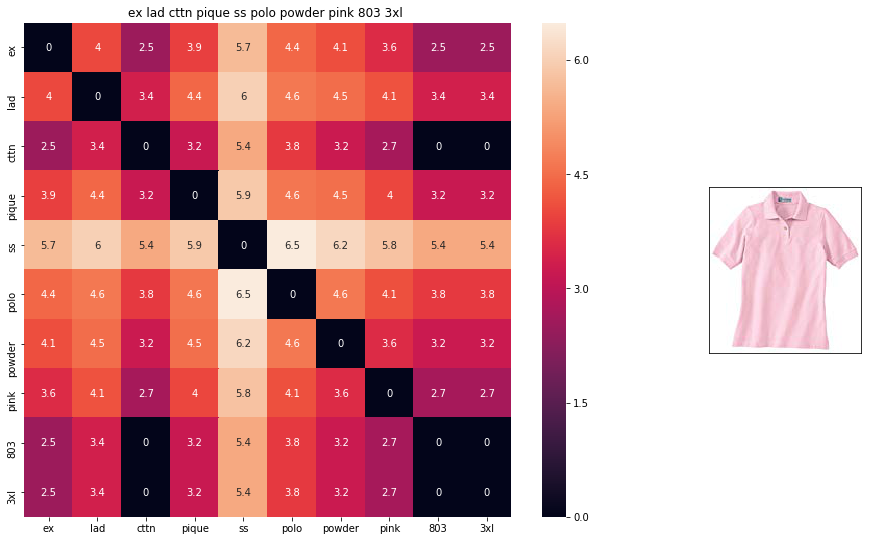

ASIN : B00ELC644O
BRAND : Ash City
euclidean distance from given input image : 0.0


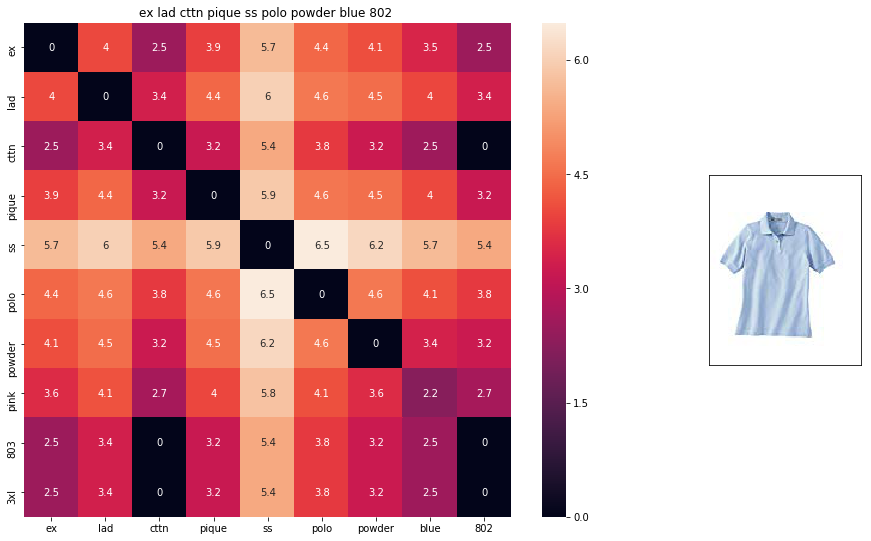

ASIN : B00ELC5OC2
BRAND : Ash City
euclidean distance from given input image : 0.2676299


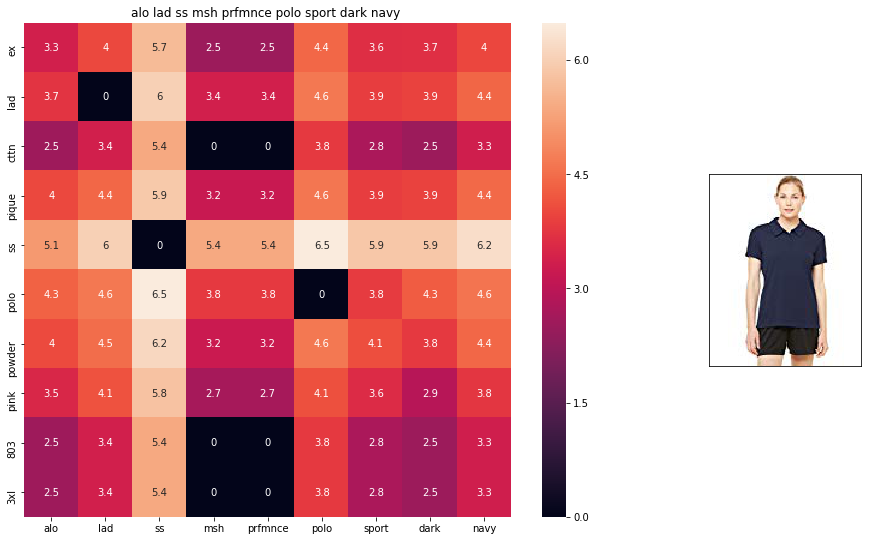

ASIN : B00QFRYZ1C
BRAND : All Sport
euclidean distance from given input image : 0.79917765


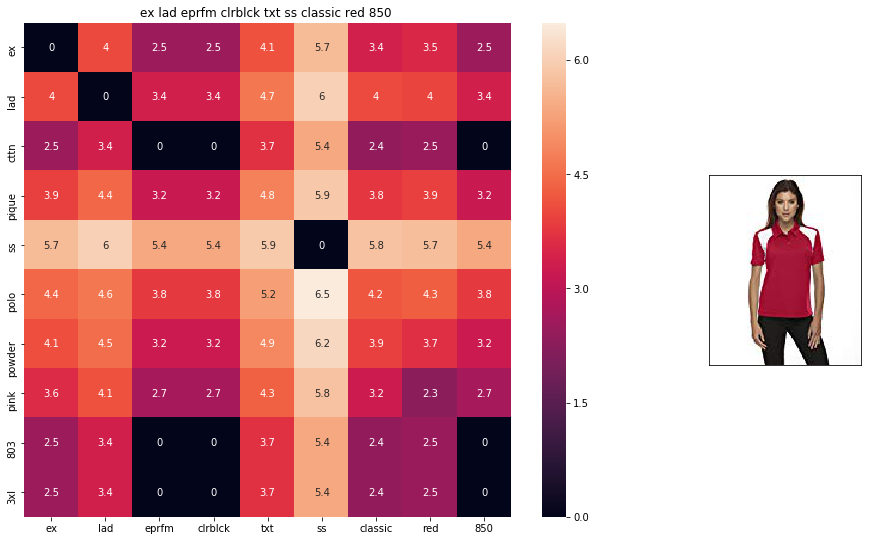

ASIN : B00ELC7WFO
BRAND : Ash City
euclidean distance from given input image : 0.8297222


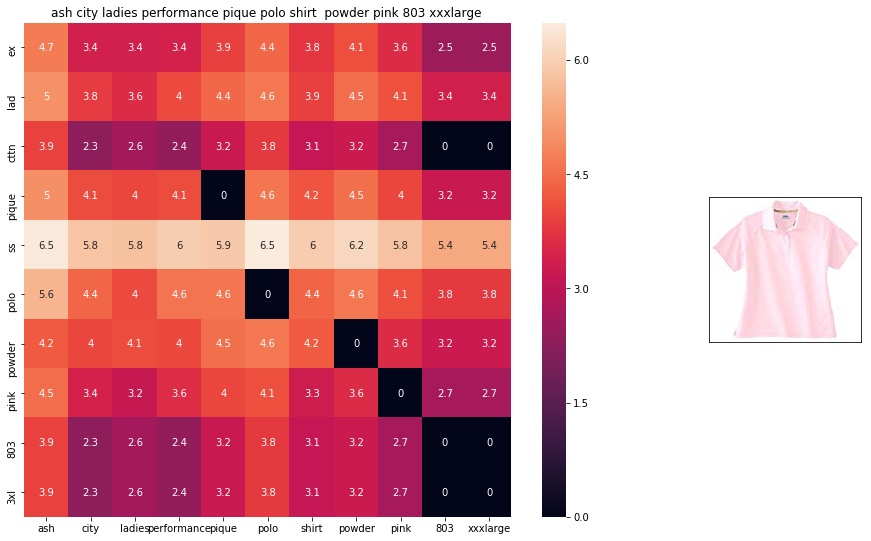

ASIN : B01GESY7FU
BRAND : Ash City - Extreme
euclidean distance from given input image : 0.8482638


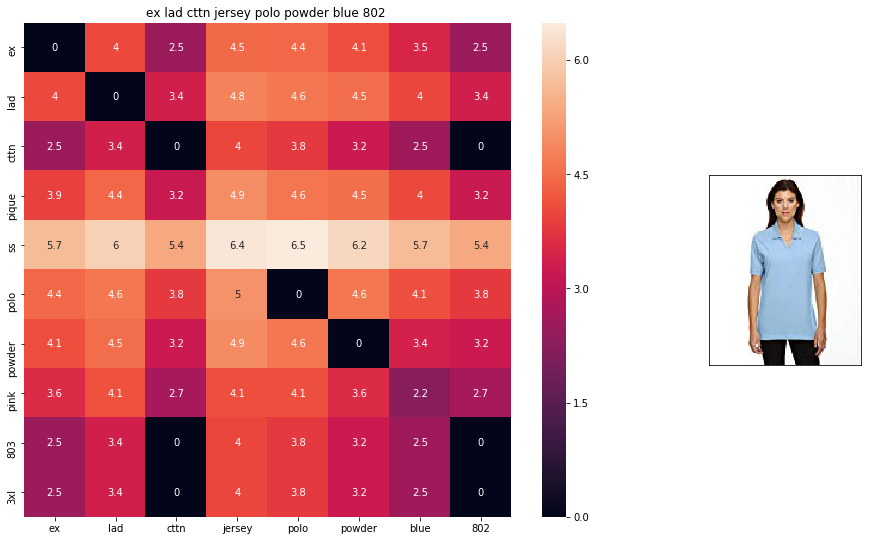

ASIN : B00ELCAEEU
BRAND : Ash City
euclidean distance from given input image : 0.85375047


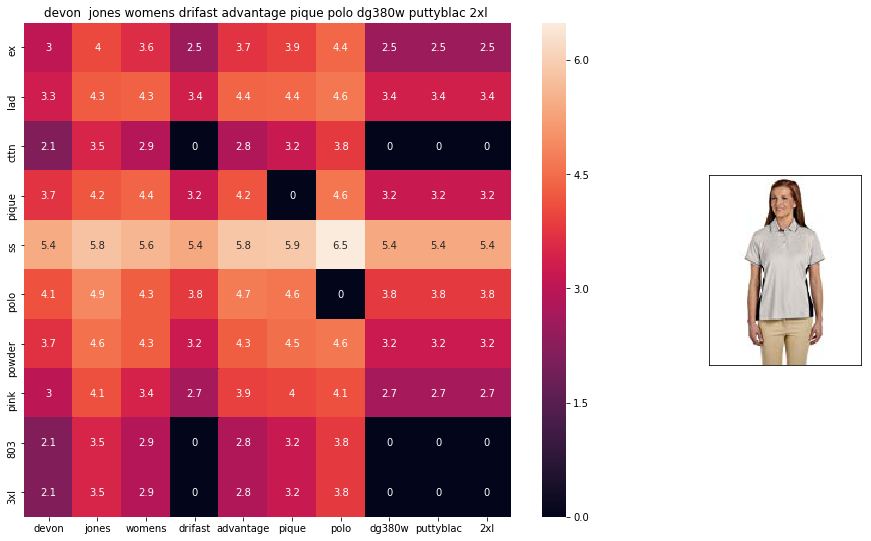

ASIN : B007QCCB98
BRAND : Devon & Jones
euclidean distance from given input image : 0.8971433


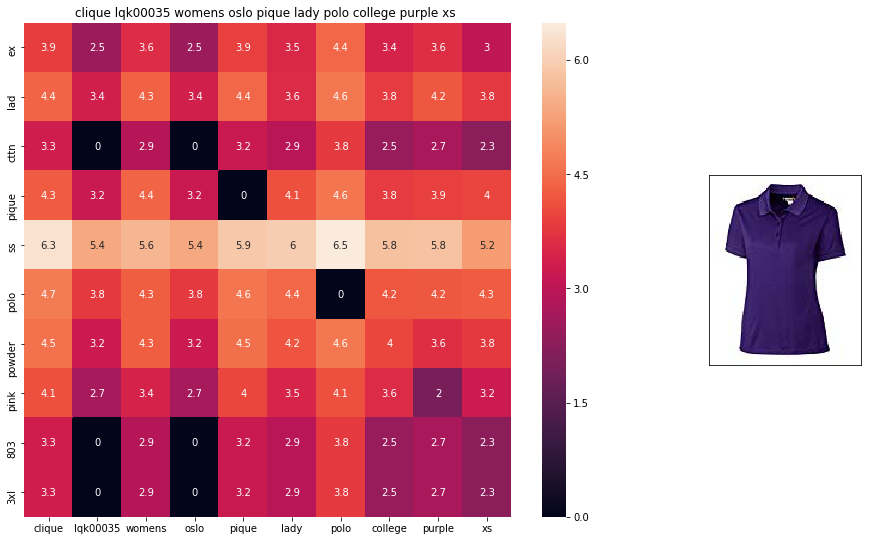

ASIN : B015D4B3DU
BRAND : Clique
euclidean distance from given input image : 0.903216


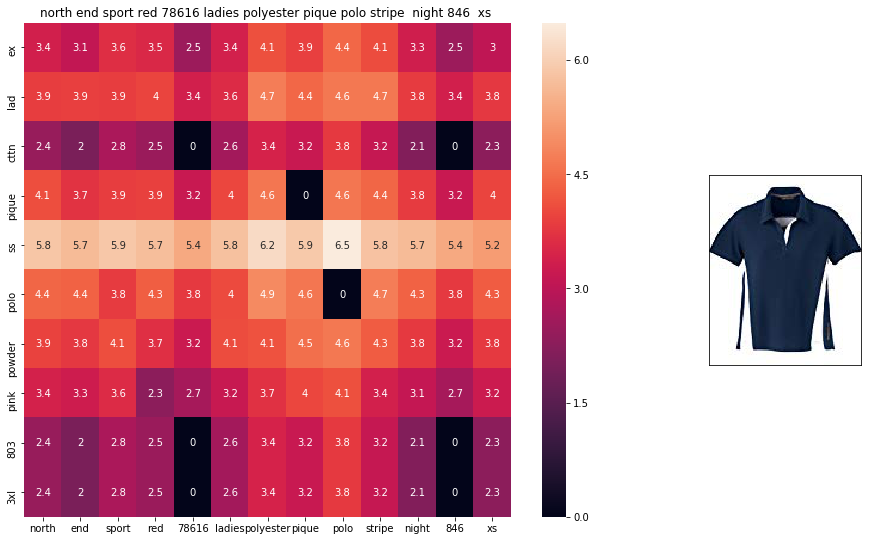

ASIN : B00R9D6V2M
BRAND : Ash City - North End Sport Red
euclidean distance from given input image : 0.90331894


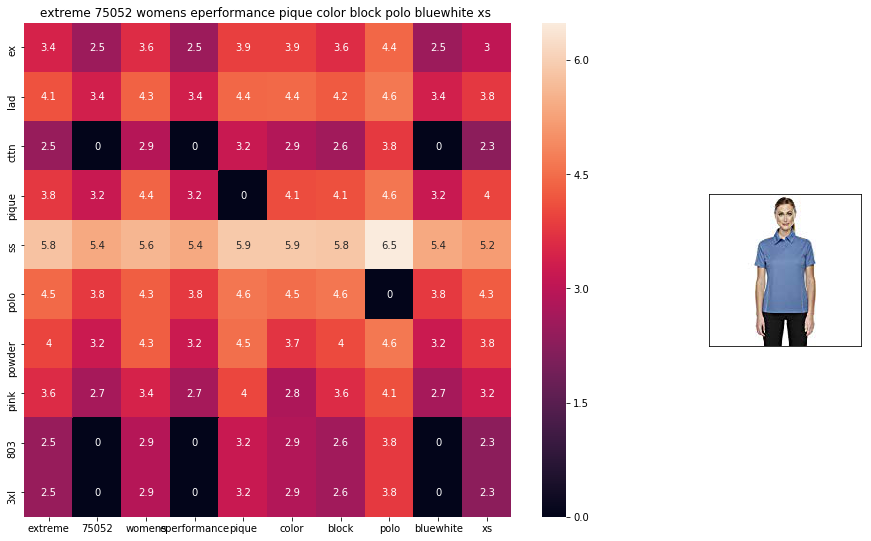

ASIN : B01N6JIRTC
BRAND : Extreme EDRY
euclidean distance from given input image : 0.9195622


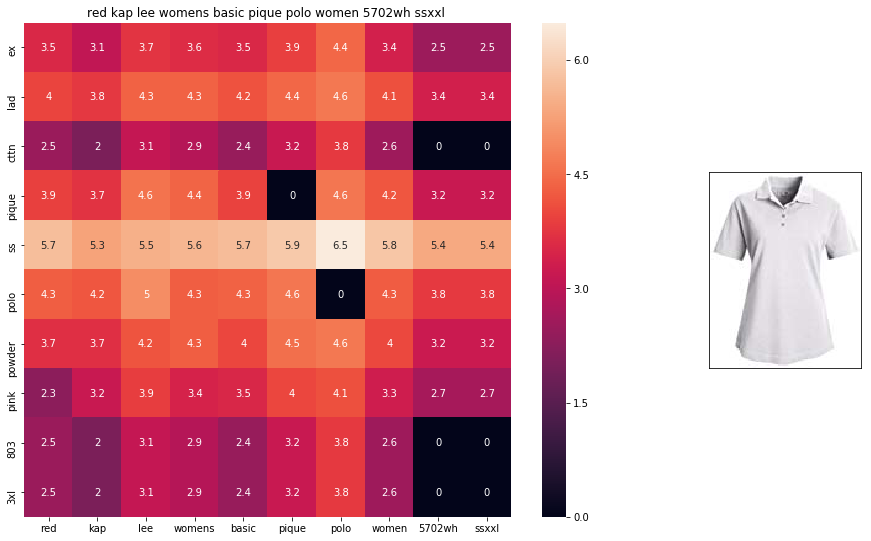

ASIN : B00AQ4GW7U
BRAND : Red Kap
euclidean distance from given input image : 0.921142


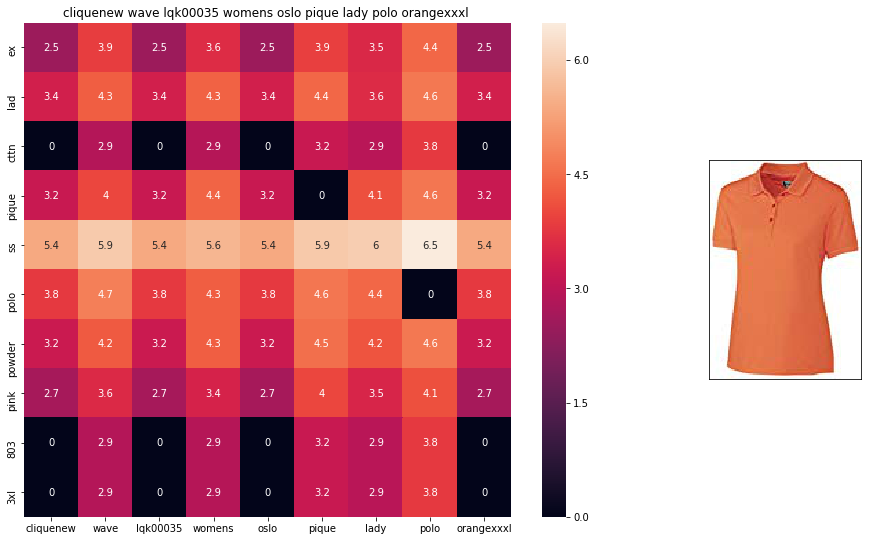

ASIN : B015D4BMPY
BRAND : Clique
euclidean distance from given input image : 0.9259974


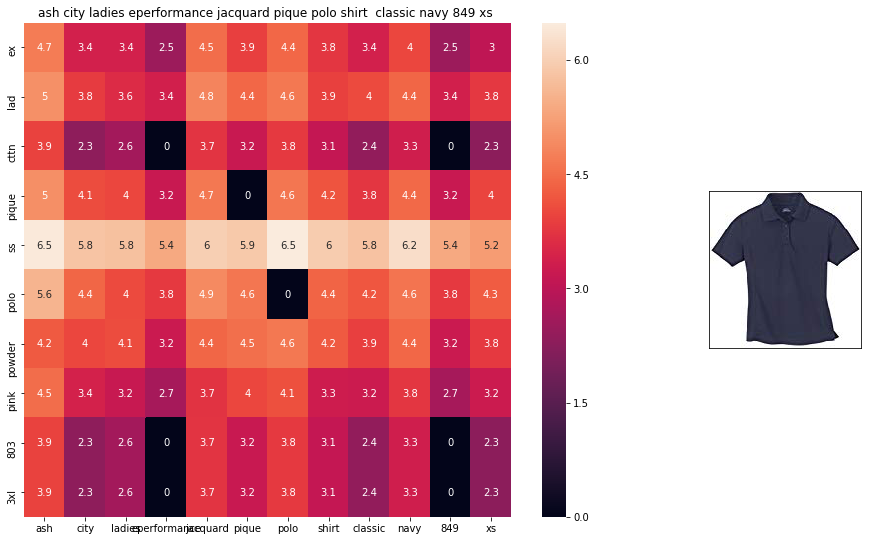

ASIN : B01GESYKQQ
BRAND : Ash City - Extreme
euclidean distance from given input image : 0.92999625


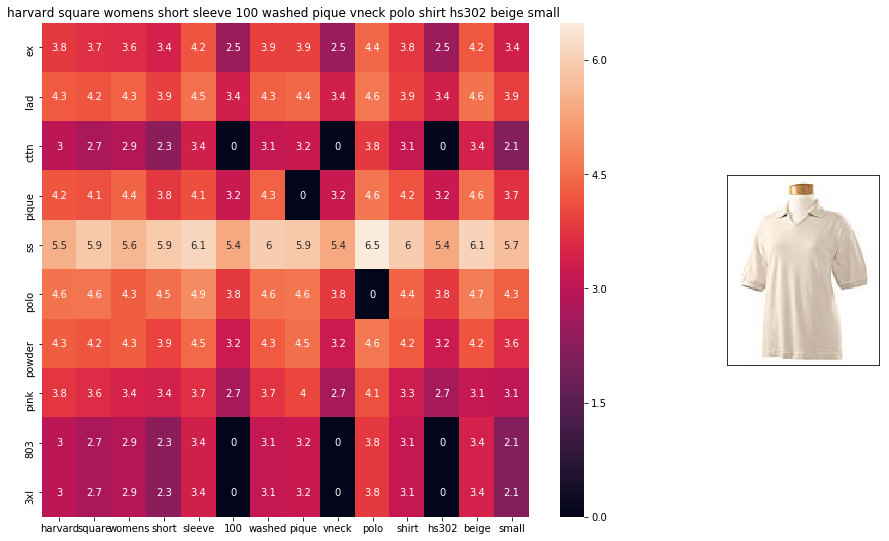

ASIN : B00RVZT4V8
BRAND : Harvard Square
euclidean distance from given input image : 0.9340041


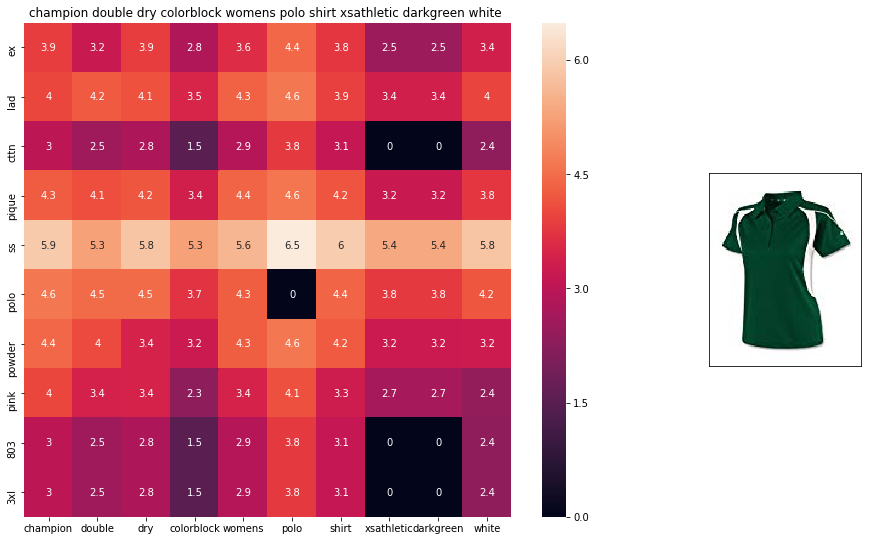

ASIN : B00506ZHVQ
BRAND : Champion
euclidean distance from given input image : 0.9368872


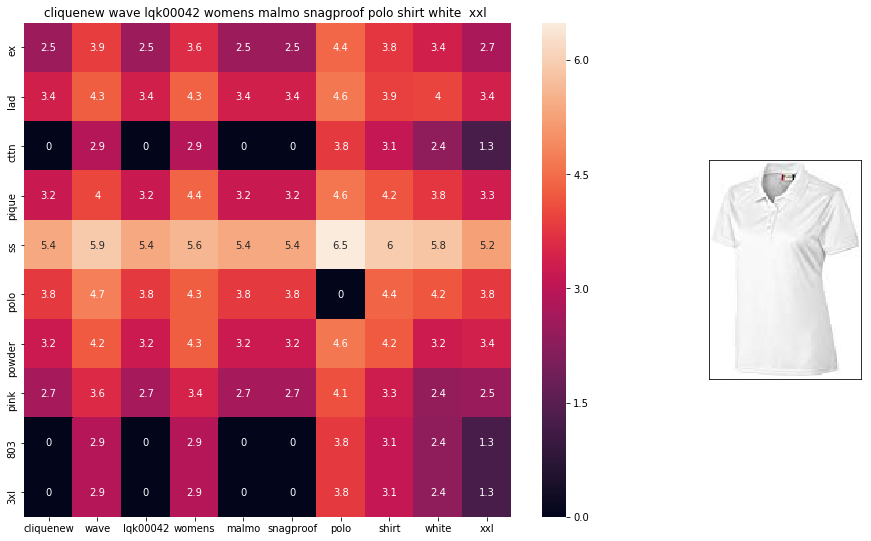

ASIN : B00PVKDP5G
BRAND : Clique
euclidean distance from given input image : 0.93939525


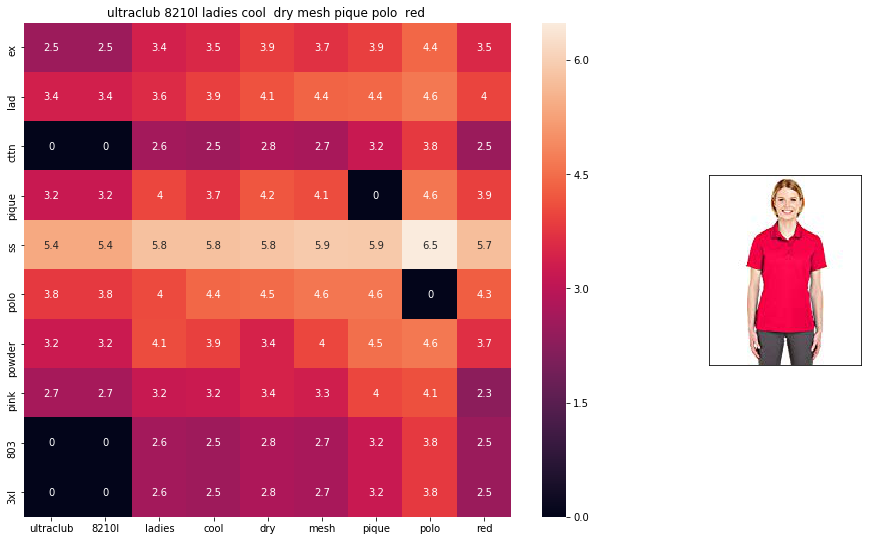

ASIN : B00I2QDDW6
BRAND : Ultra Club
euclidean distance from given input image : 0.94003457


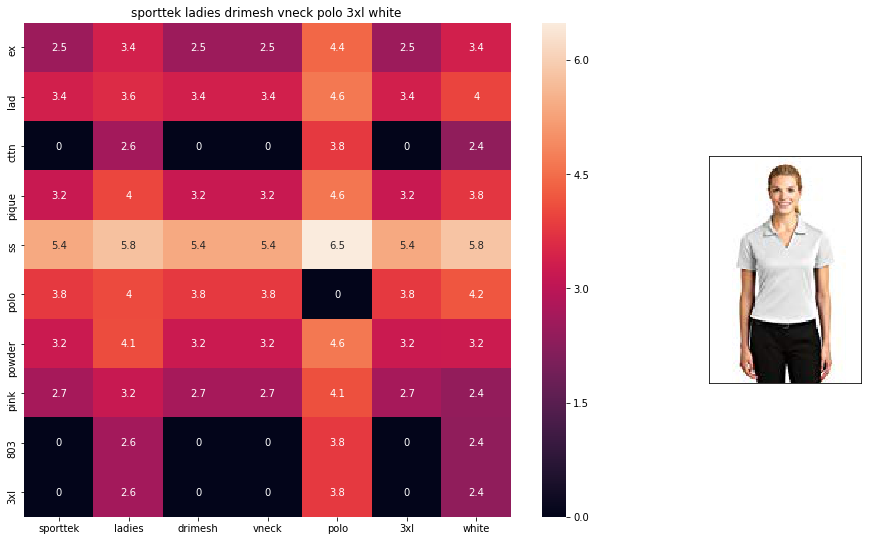

ASIN : B008PVBYWY
BRAND : Sport-Tek
euclidean distance from given input image : 0.944951


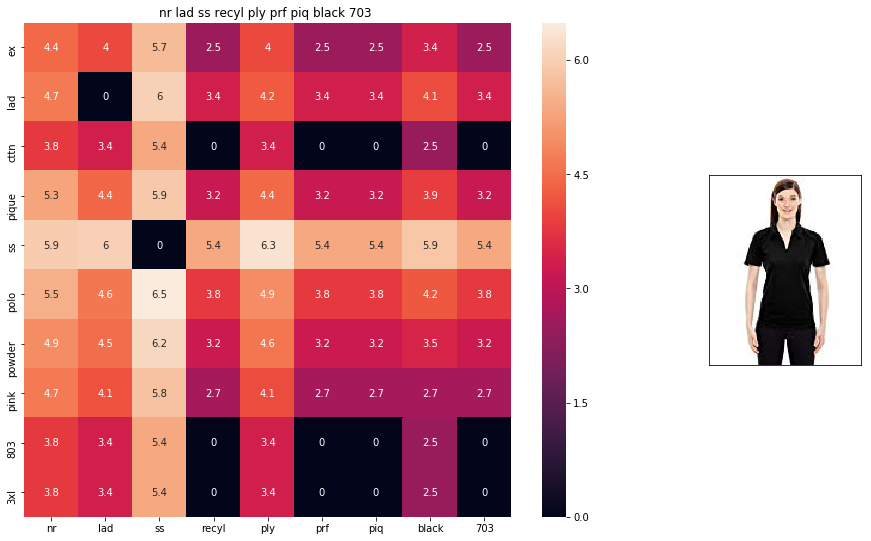

ASIN : B00ELC31DQ
BRAND : Ash City
euclidean distance from given input image : 0.94679695


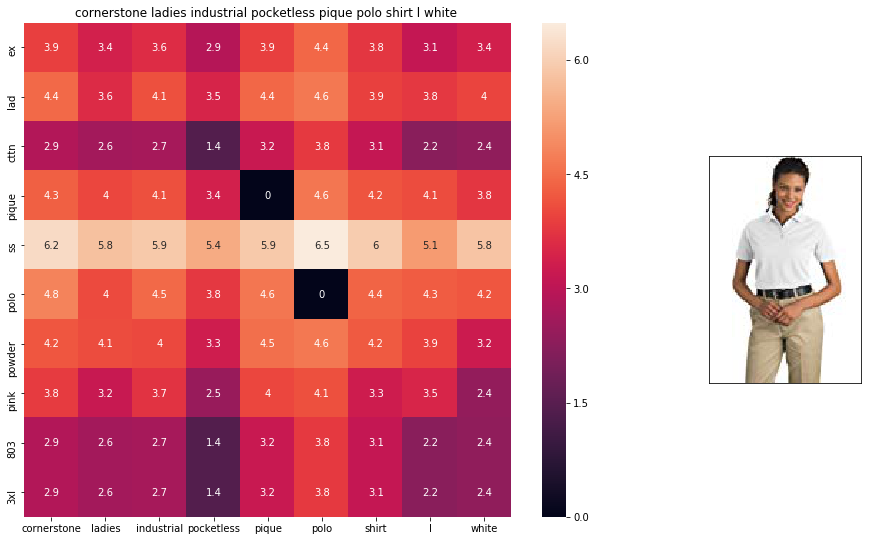

ASIN : B016WMNL0K
BRAND : Cornerstone
euclidean distance from given input image : 0.9470555


In [34]:
avg_w2v_model(1152, 20)

#### IDF weighted Word2Vec for product similarity

In [35]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [36]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j


#### Lets get similar products for product ID 1152 and 104 using Avg W2V

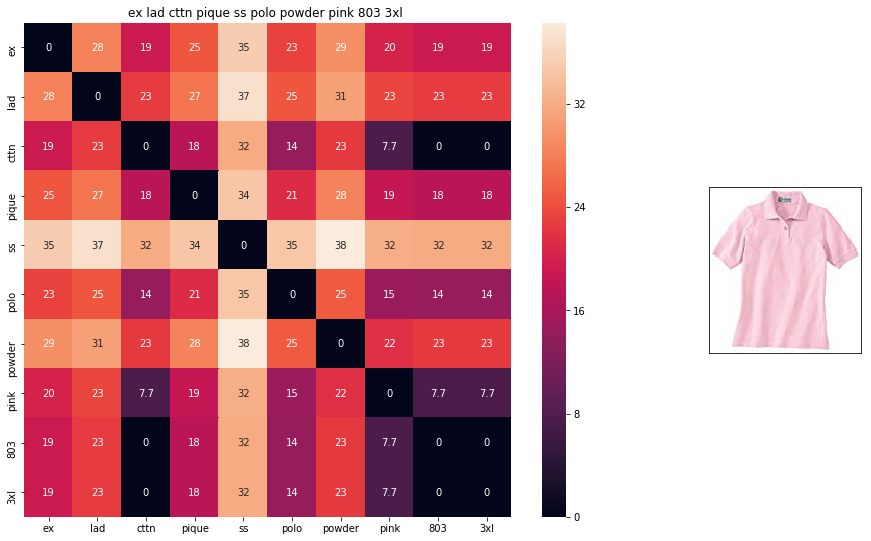

ASIN : B00ELC644O
Brand : Ash City
euclidean distance from input : 0.0


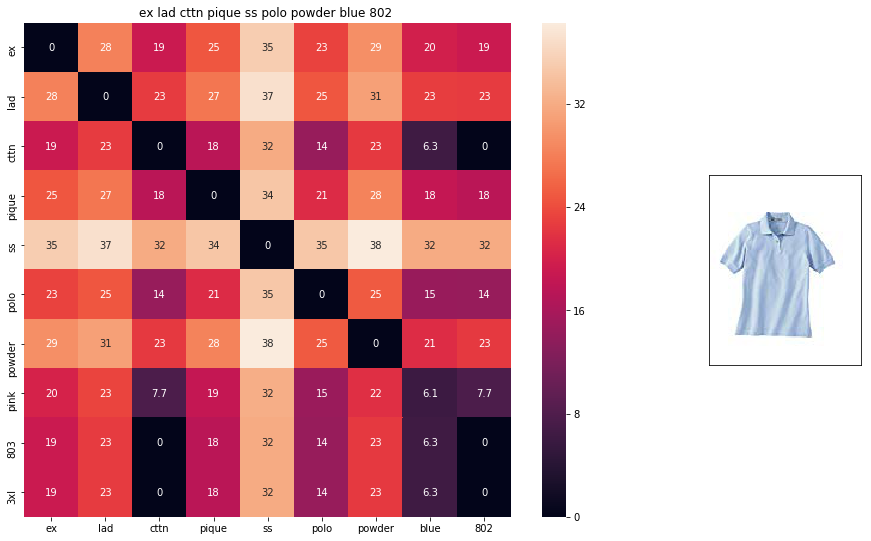

ASIN : B00ELC5OC2
Brand : Ash City
euclidean distance from input : 0.9502182


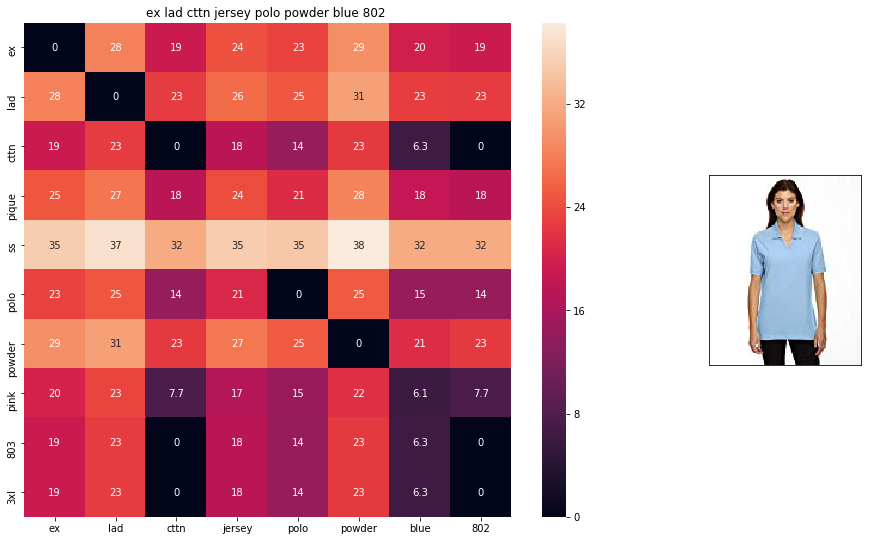

ASIN : B00ELCAEEU
Brand : Ash City
euclidean distance from input : 4.3657575


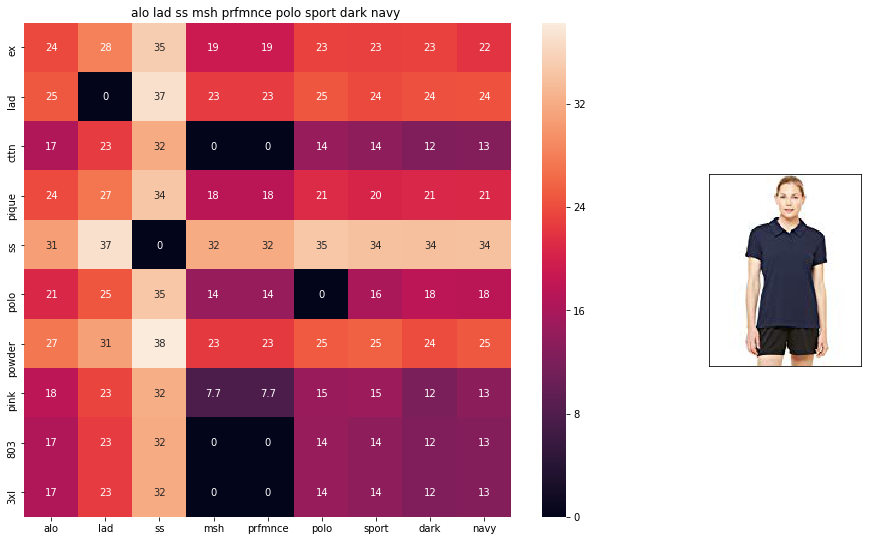

ASIN : B00QFRYZ1C
Brand : All Sport
euclidean distance from input : 4.4558196


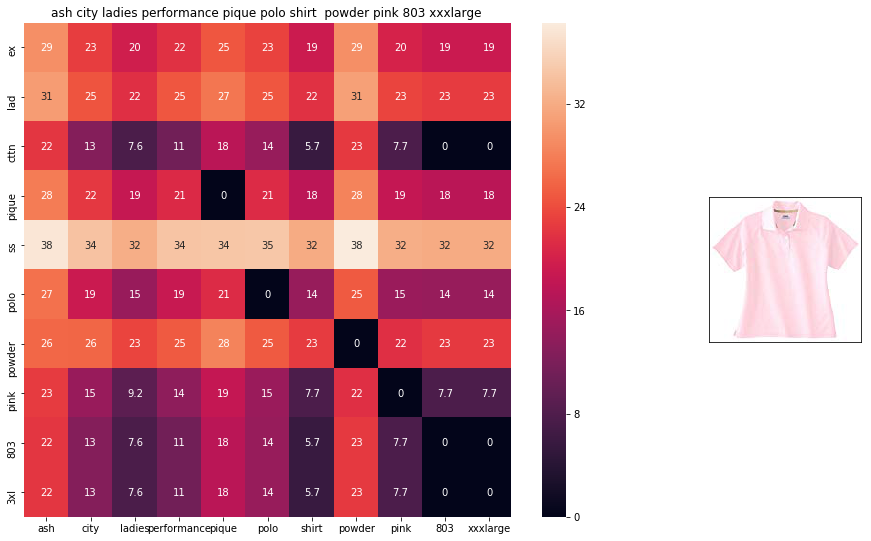

ASIN : B01GESY7FU
Brand : Ash City - Extreme
euclidean distance from input : 5.112808


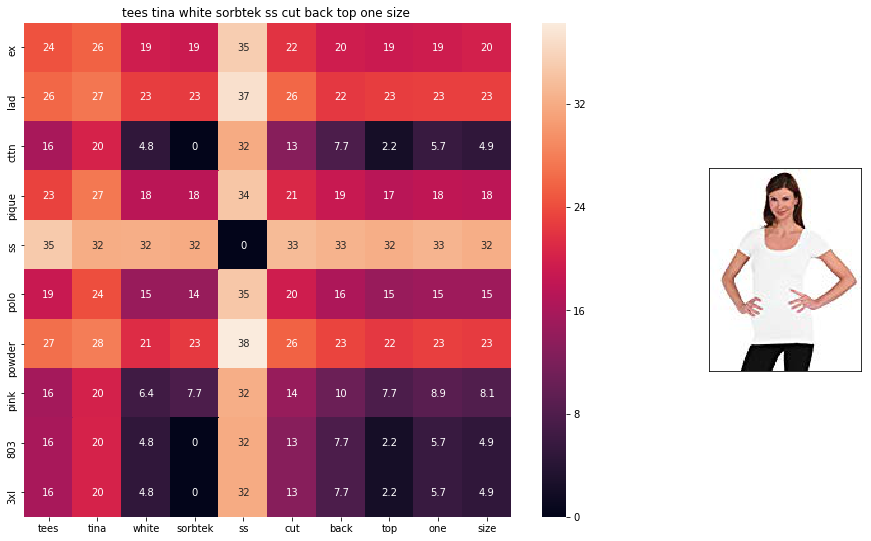

ASIN : B073KRRNM4
Brand : Tees by Tina
euclidean distance from input : 5.1140466


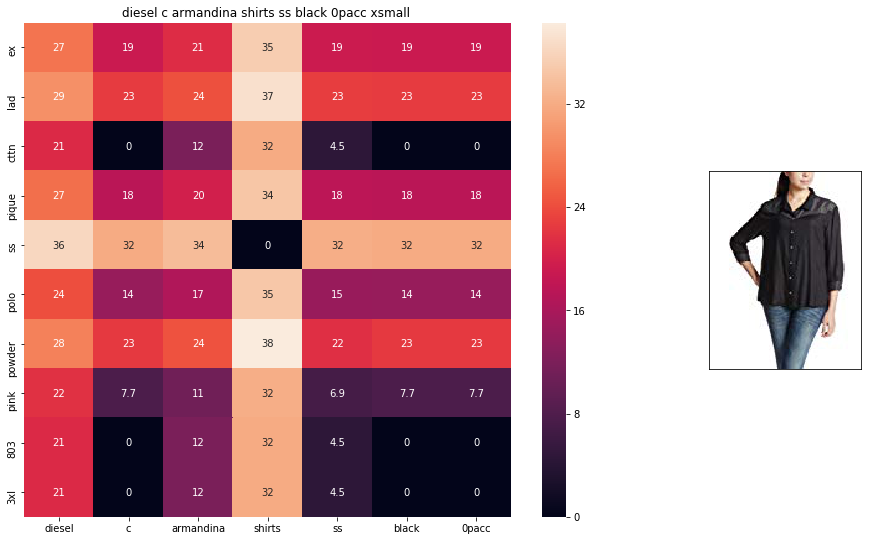

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 5.1422315


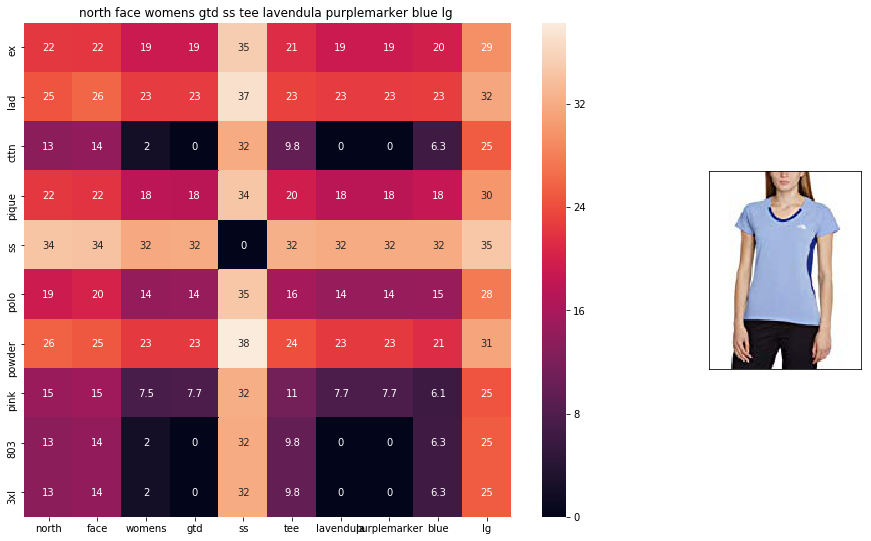

ASIN : B00DEN0V5O
Brand : The North Face
euclidean distance from input : 5.1691957


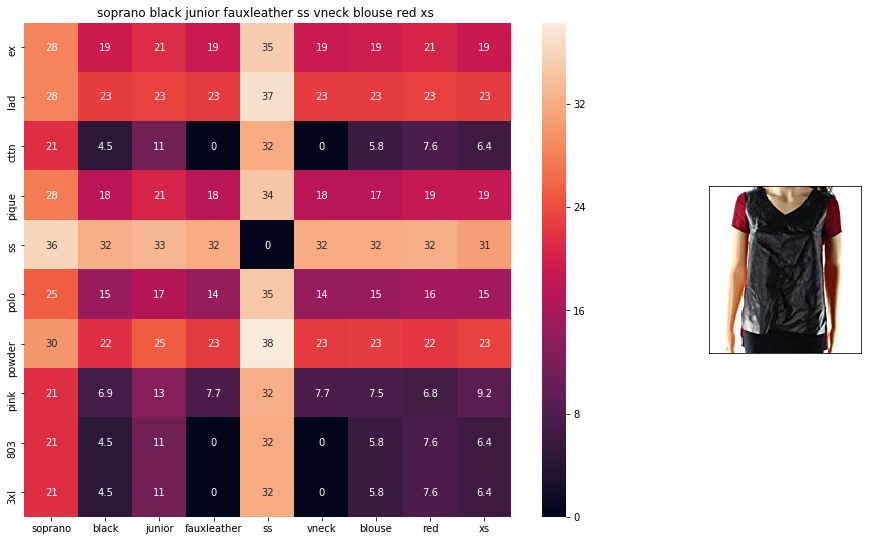

ASIN : B071Z8NX2P
Brand : Soprano
euclidean distance from input : 5.2276573


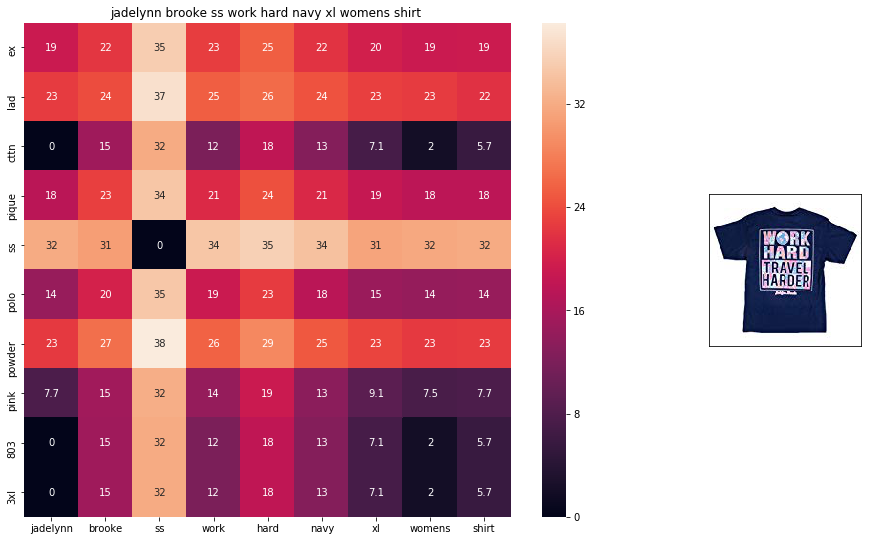

ASIN : B00OB84954
Brand : Liuqiuhu
euclidean distance from input : 5.350311


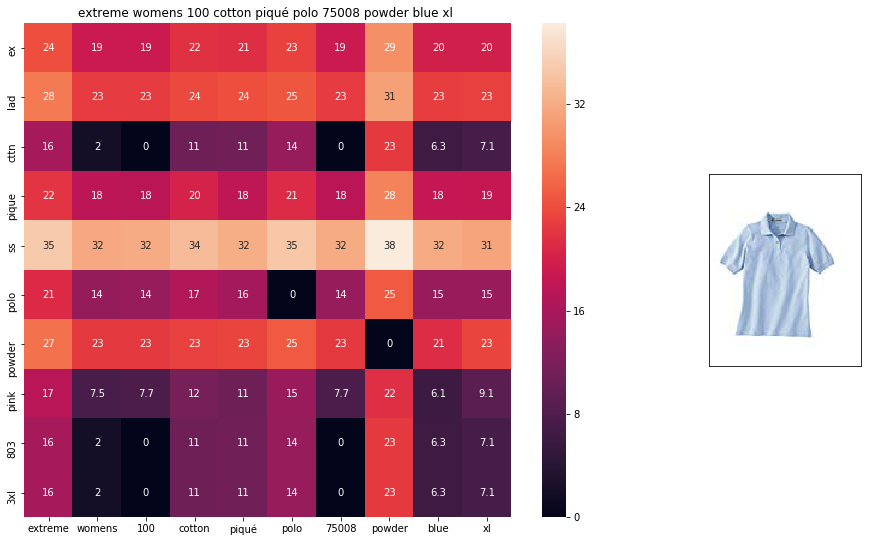

ASIN : B00ELC5A4Y
Brand : Ash City
euclidean distance from input : 5.35666


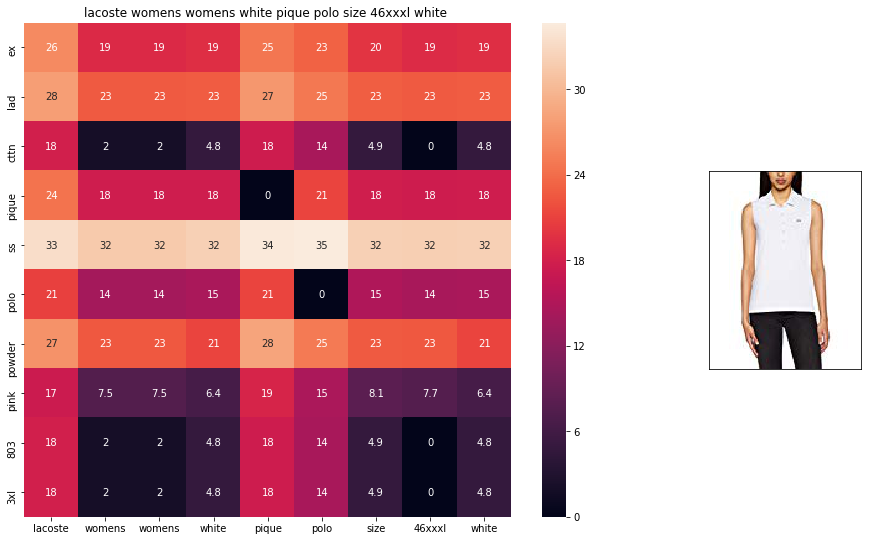

ASIN : B01M2AAJNP
Brand : Lacoste
euclidean distance from input : 5.3573294


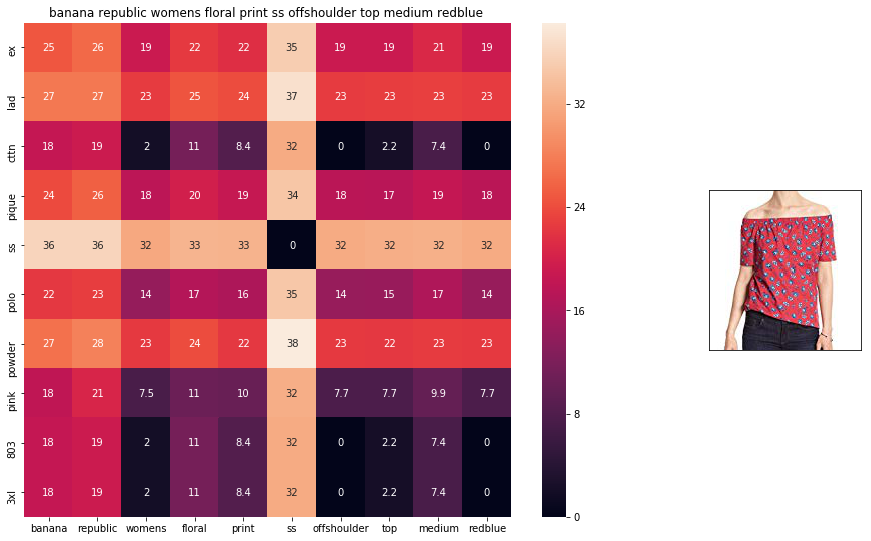

ASIN : B0746ZVMJ7
Brand : Banana Republic Factory Store
euclidean distance from input : 5.363956


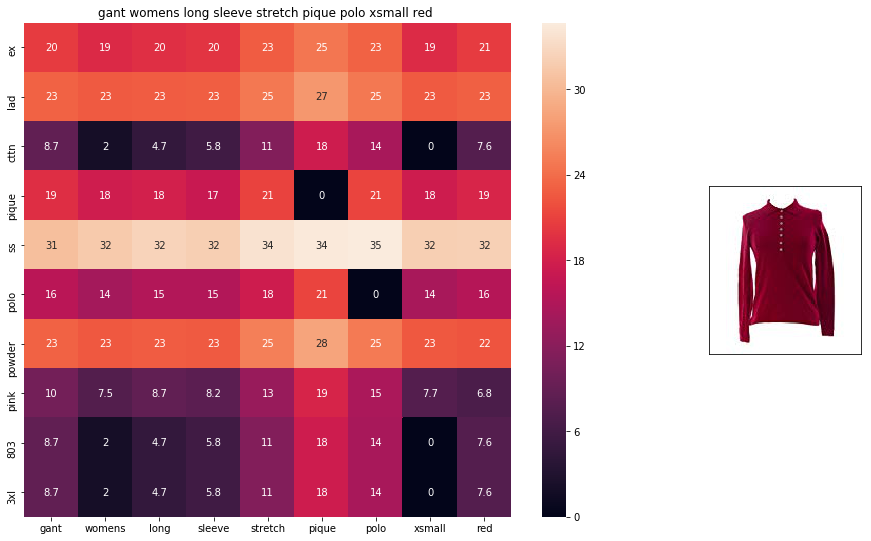

ASIN : B010TIBIEO
Brand : GANT
euclidean distance from input : 5.3793964


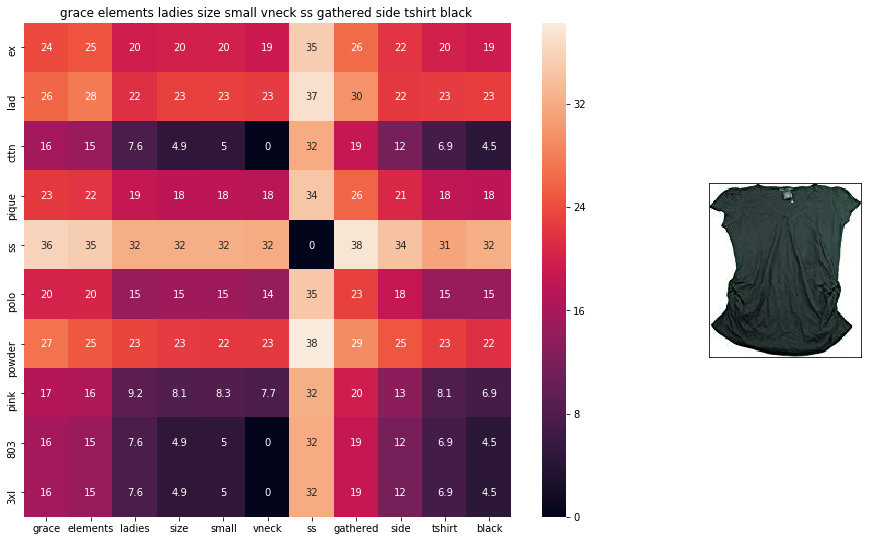

ASIN : B01N44F9Q9
Brand : Grace Elements
euclidean distance from input : 5.388655


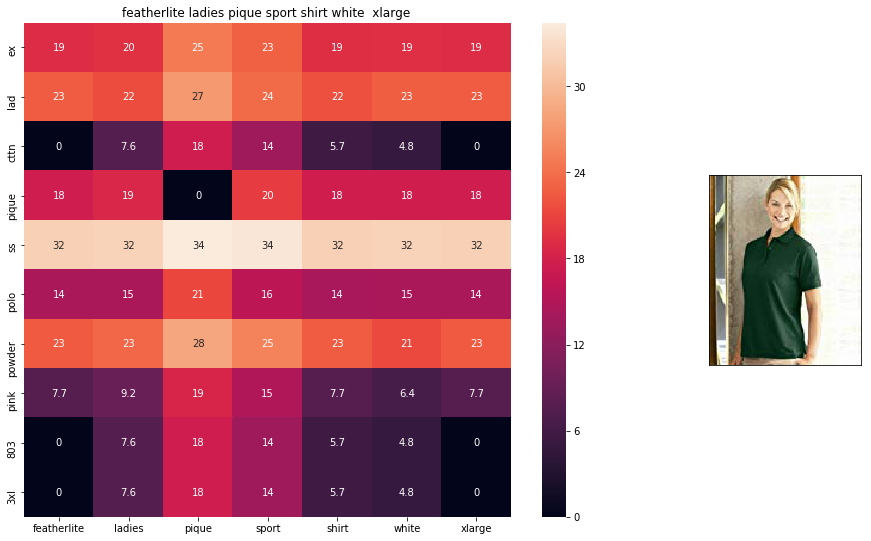

ASIN : B003BSQ1YM
Brand : FeatherLite
euclidean distance from input : 5.4021635


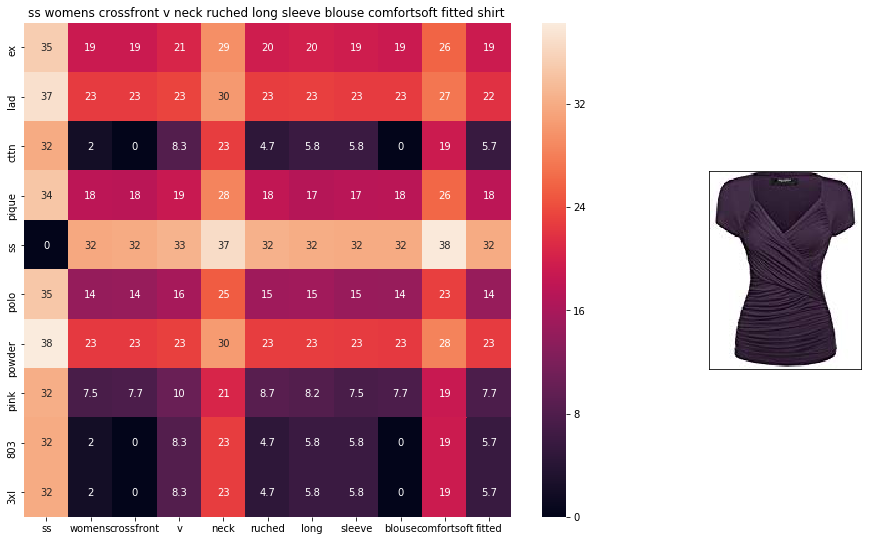

ASIN : B06XK5TMSJ
Brand : S&S-women
euclidean distance from input : 5.413485


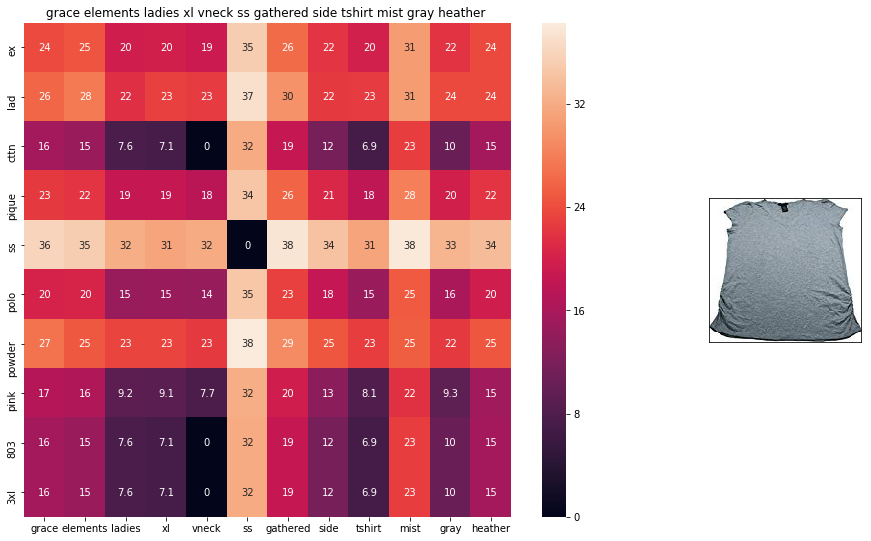

ASIN : B01NAIHYF6
Brand : Grace Elements
euclidean distance from input : 5.423625


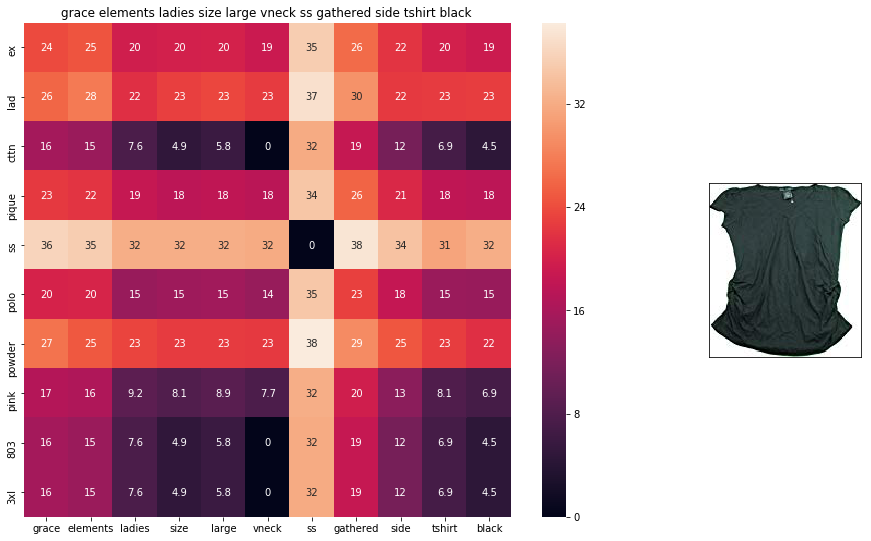

ASIN : B01M5FU5Y9
Brand : Grace Elements
euclidean distance from input : 5.4275784


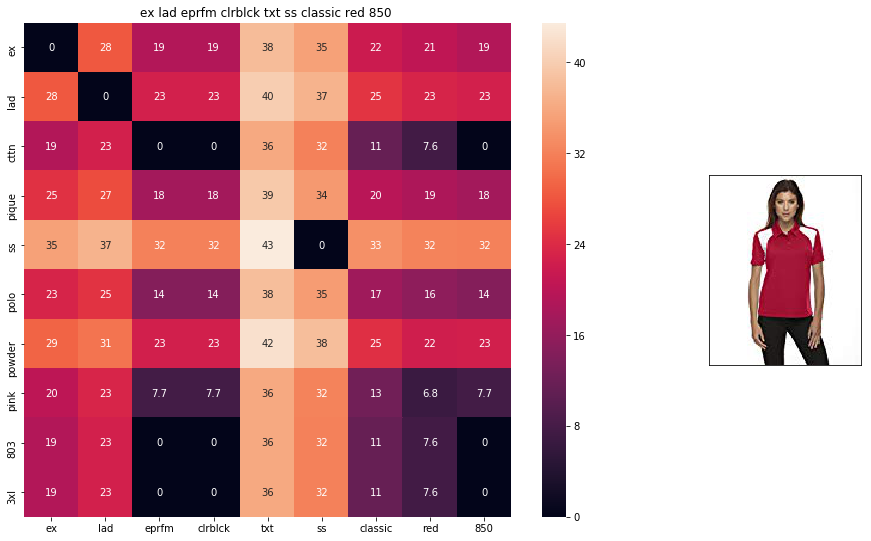

ASIN : B00ELC7WFO
Brand : Ash City
euclidean distance from input : 5.4276404


In [37]:
weighted_w2v_model(1152, 20)

#### Weighted similarity using brand and color

In [38]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [39]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [40]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


# in the give heat map, each cell contains the euclidean distance between words i, j

#### Lets get similar products for product ID 1152 and 104 using brand and color

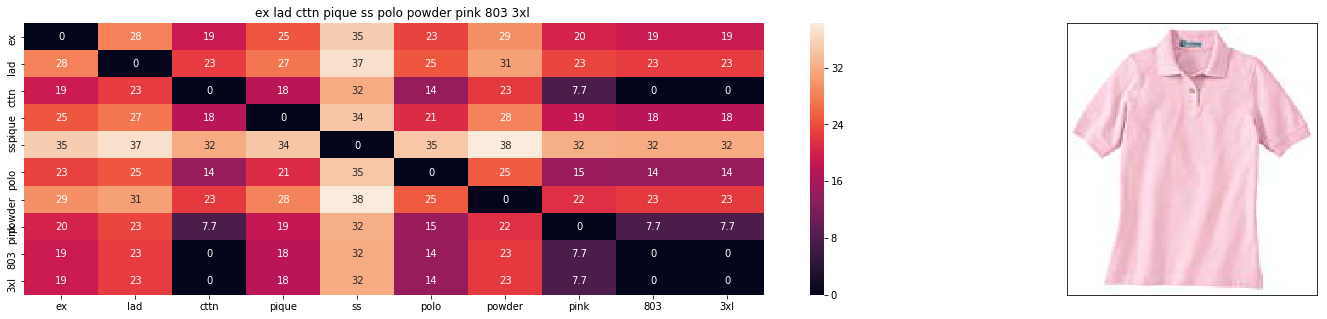

ASIN : B00ELC644O
Brand : Ash City
euclidean distance from input : 0.0


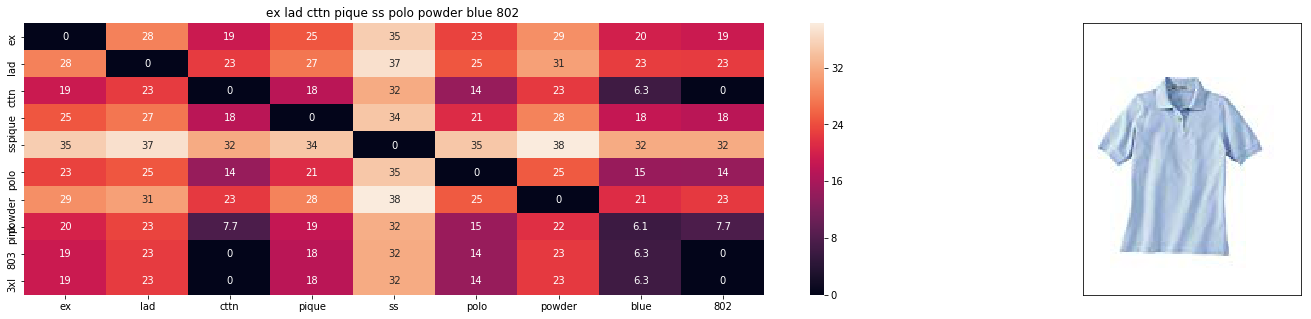

ASIN : B00ELC5OC2
Brand : Ash City
euclidean distance from input : 1.1822158815283443


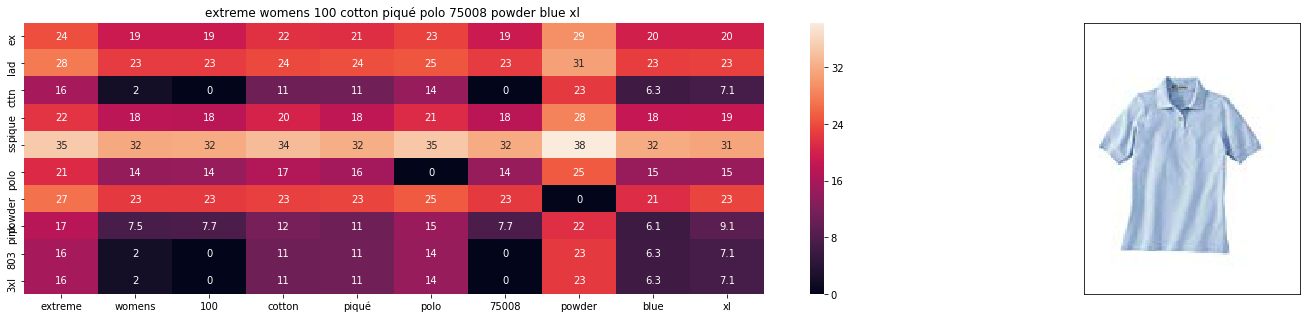

ASIN : B00ELC5A4Y
Brand : Ash City
euclidean distance from input : 3.3854366304297114


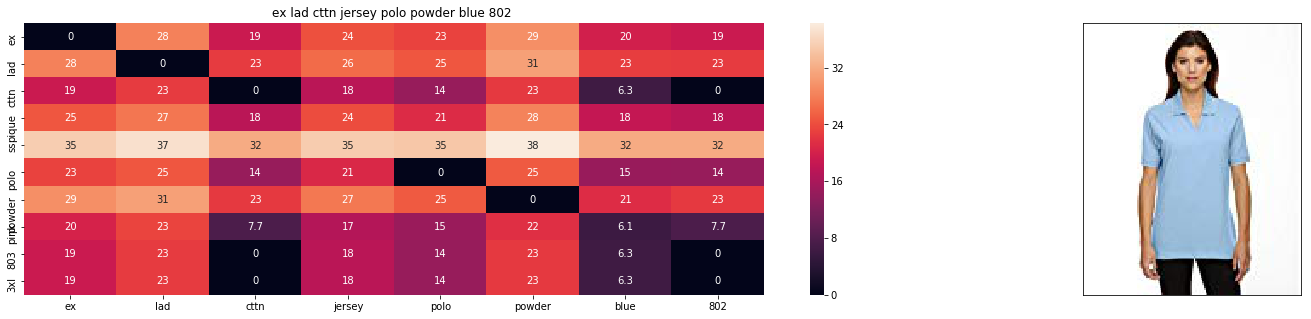

ASIN : B00ELCAEEU
Brand : Ash City
euclidean distance from input : 3.4076235563891473


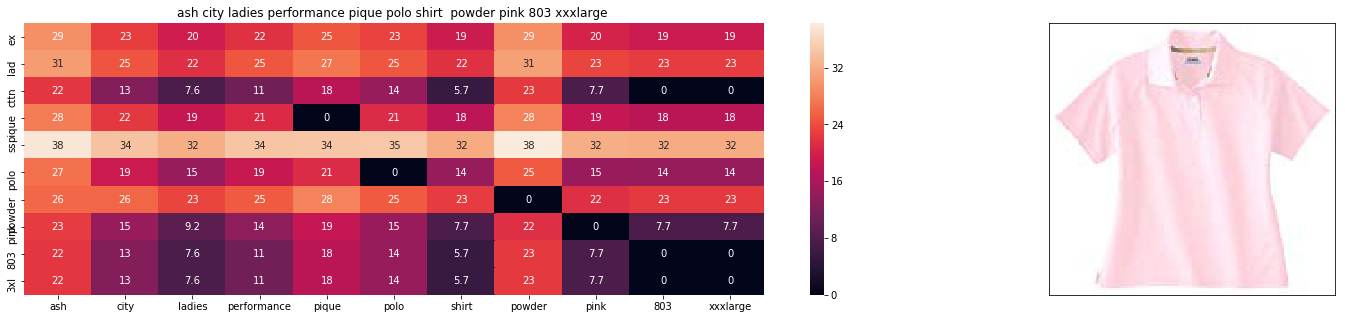

ASIN : B01GESY7FU
Brand : Ash City - Extreme
euclidean distance from input : 3.4224295175539696


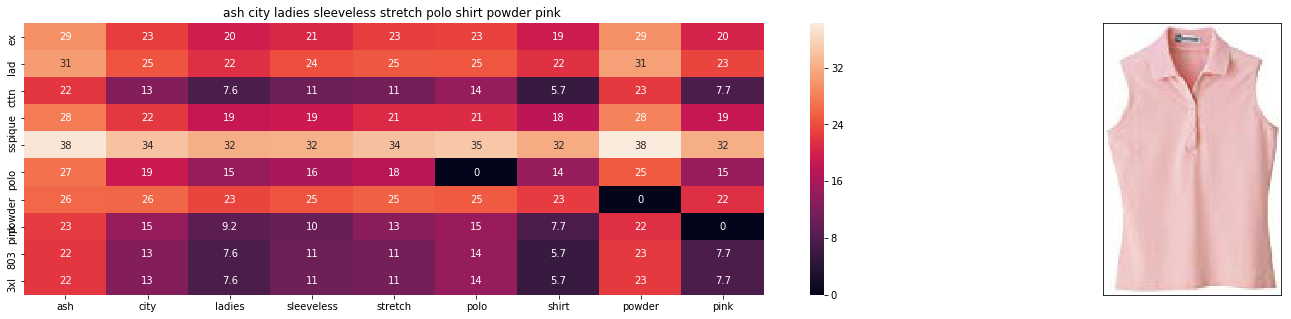

ASIN : B002KG40KS
Brand : Ash City
euclidean distance from input : 3.51109619140625


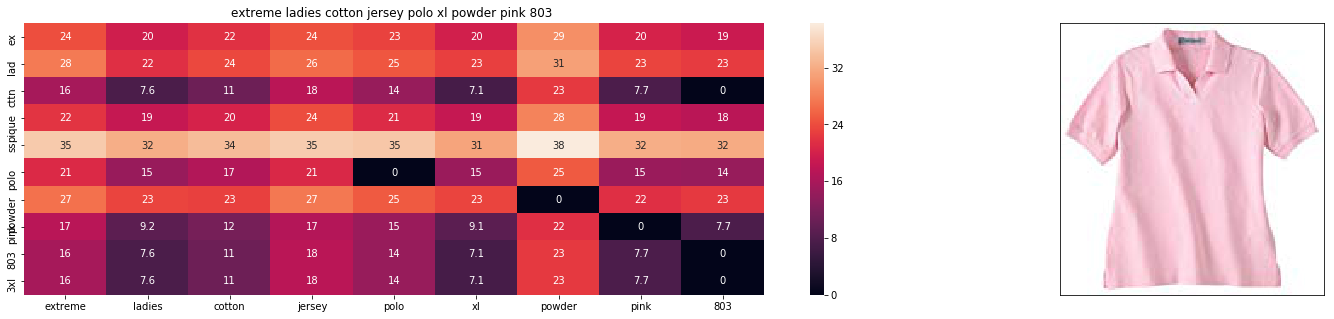

ASIN : B014WC6TTW
Brand : Ash City - Extreme
euclidean distance from input : 3.6027550256716454


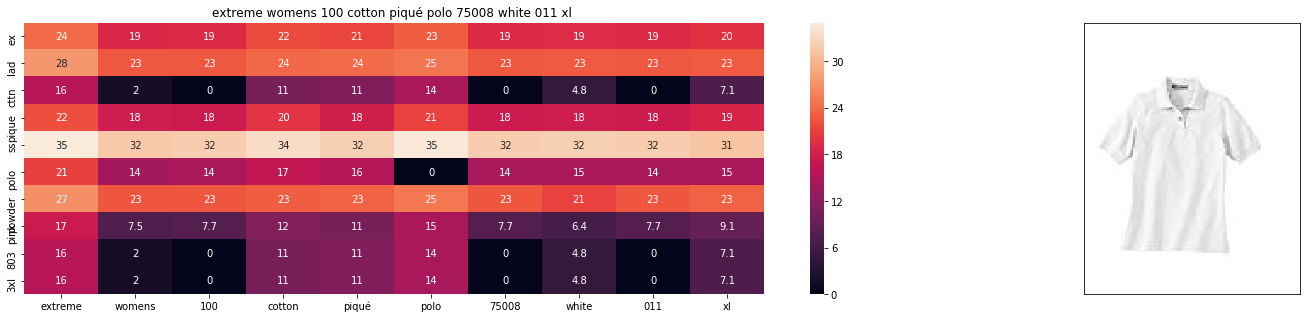

ASIN : B00ELC56MK
Brand : Ash City
euclidean distance from input : 3.6120552064795164


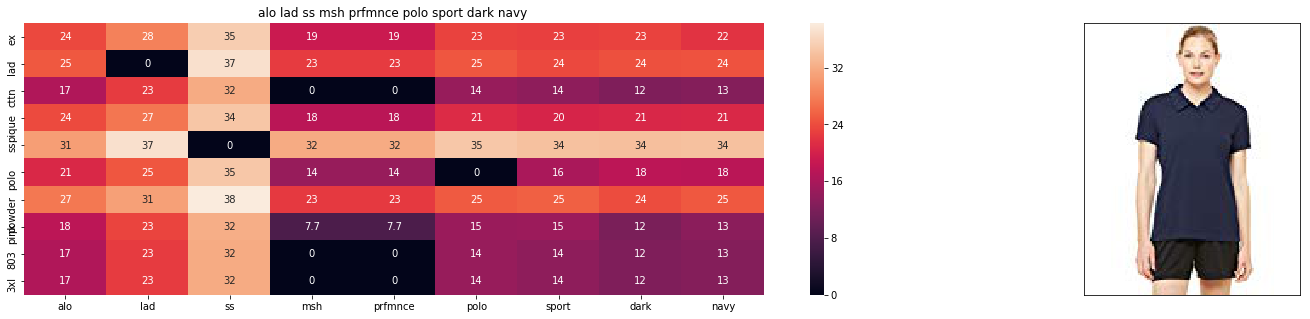

ASIN : B00QFRYZ1C
Brand : All Sport
euclidean distance from input : 3.642123413447314


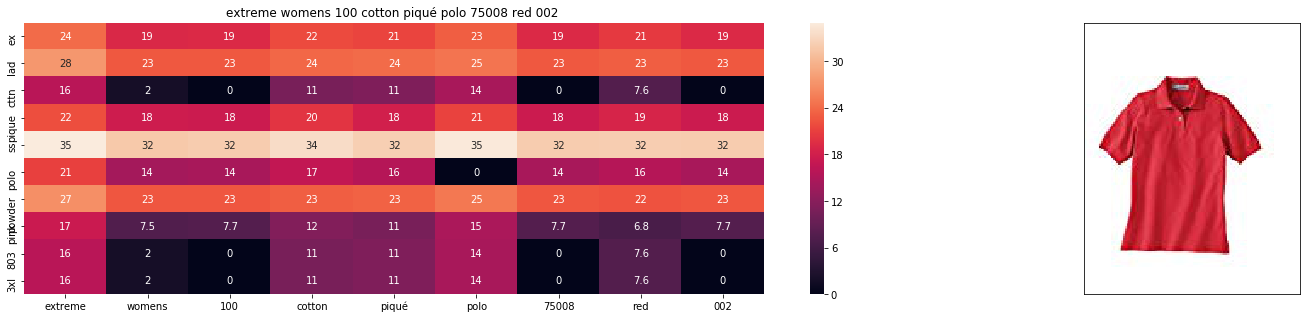

ASIN : B00ELC5FVM
Brand : Ash City
euclidean distance from input : 3.6569099428076415


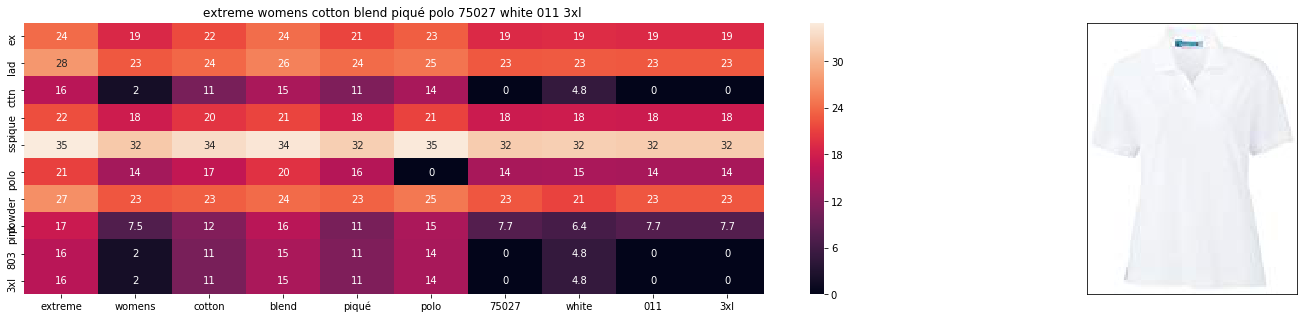

ASIN : B00ELC62WS
Brand : Ash City
euclidean distance from input : 3.680171585263696


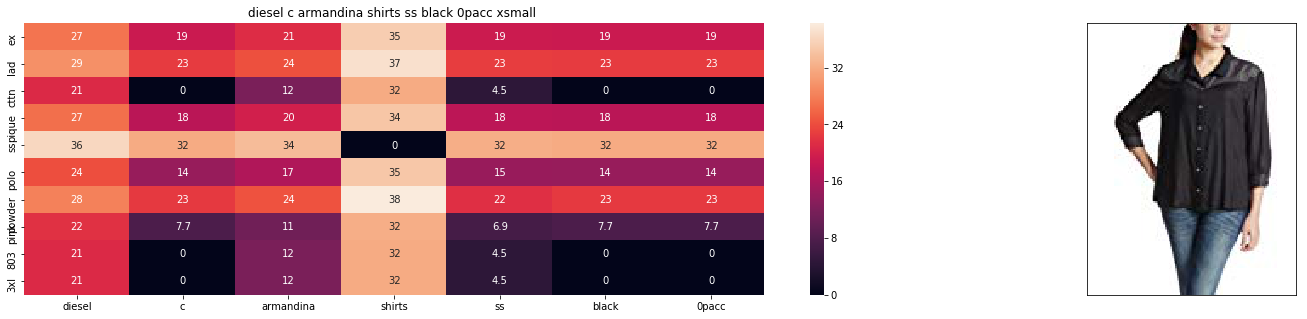

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 3.689149673259172


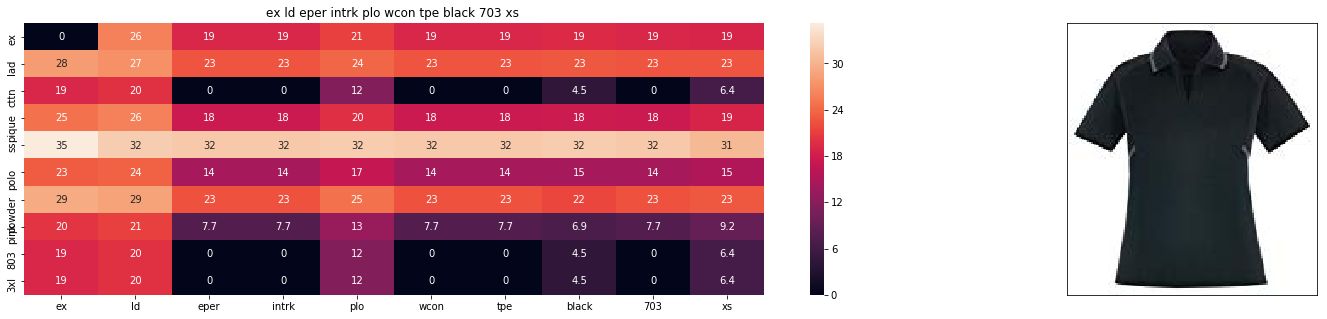

ASIN : B00JV3ODDW
Brand : Ash City
euclidean distance from input : 3.693644574927016


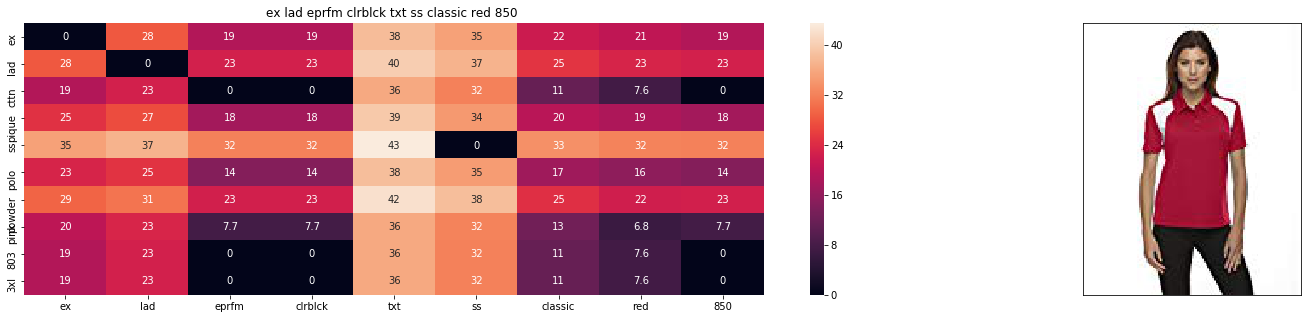

ASIN : B00ELC7WFO
Brand : Ash City
euclidean distance from input : 3.7138202667236326


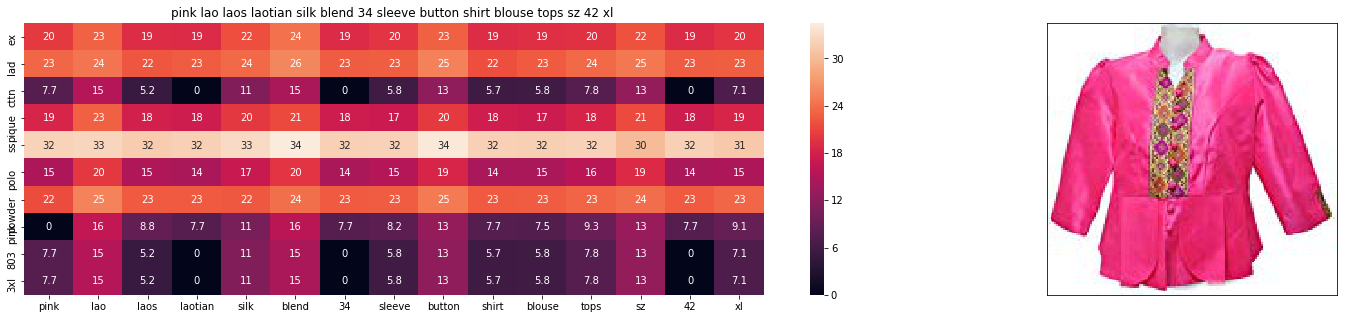

ASIN : B01JFM5R5Q
Brand : Nanon
euclidean distance from input : 3.7267550027834617


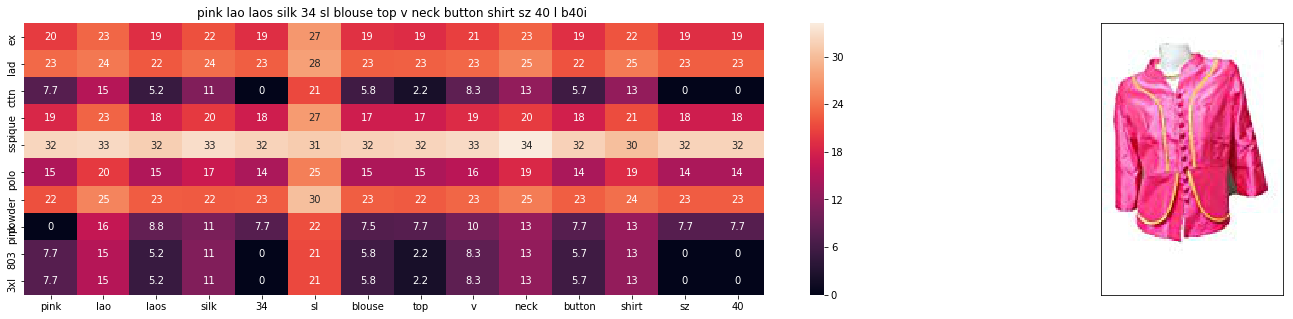

ASIN : B01IN9FY9Q
Brand : Nanon
euclidean distance from input : 3.731269696997329


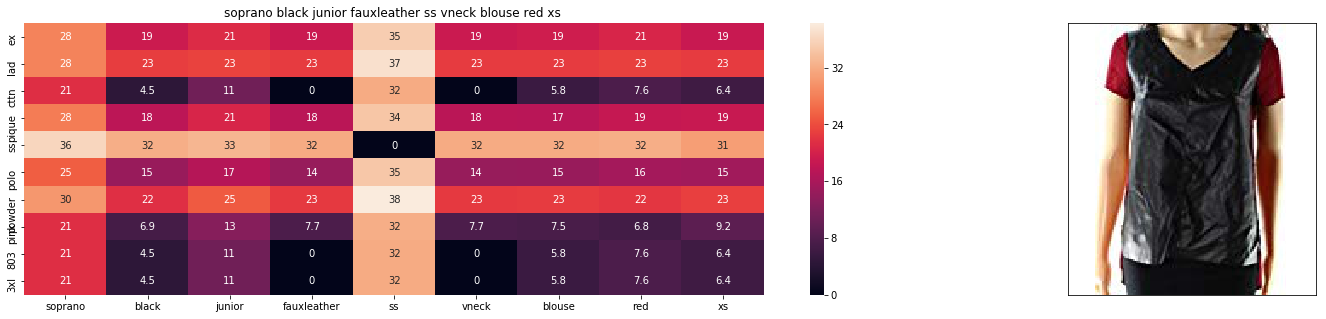

ASIN : B071Z8NX2P
Brand : Soprano
euclidean distance from input : 3.7318626478075116


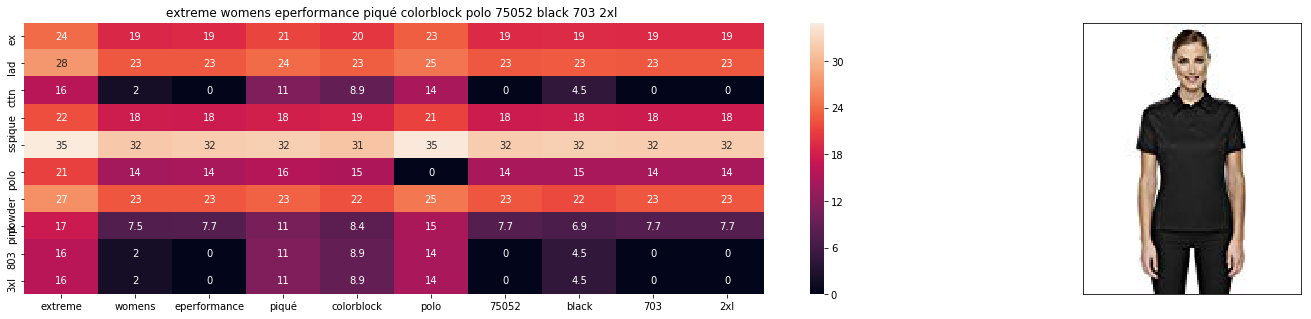

ASIN : B00ELCAAVC
Brand : Ash City
euclidean distance from input : 3.741122297094985


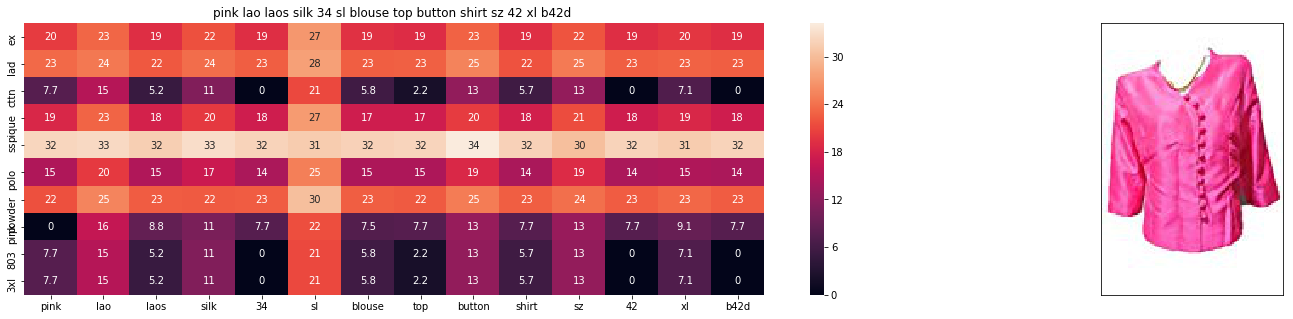

ASIN : B01IODIUR4
Brand : Nanon
euclidean distance from input : 3.7485518014895165


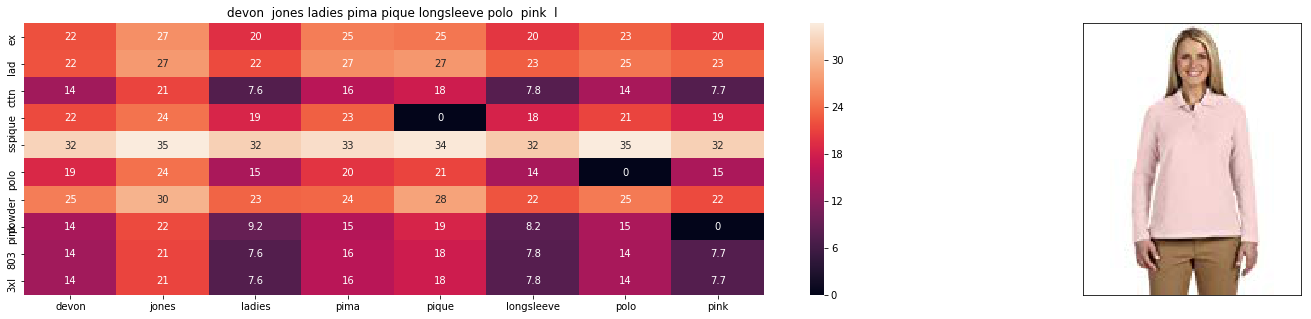

ASIN : B00MX0X2MI
Brand : Devon & Jones
euclidean distance from input : 3.750718879699707


In [41]:
idf_w2v_brand(1152, 5, 5, 20)

#### Keras and Tensorflow to extract features

In [42]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [43]:
#https://pymotw.com/2/glob/
import glob
c = glob.glob("images2/Images/*.jpg")
asin = []
for a in range(len(c)):
    asin.append(c[a].split(".")[0].split("\\")[1])
 

In [44]:
#This code takes 30-40 mins to run.
#import datetime 
#import requests
#from tqdm import tqdm


#start = datetime.datetime.now()
#print("Downloading images for feature extraction using CNN")
#for index,image_url in tqdm(data.iterrows()):
    #if image_url[0] not in asin:
       # img_data = requests.get(image_url[3]).content
        #with open('images/'+image_url[0]+'.jpg', 'wb') as handler:
            #handler.write(img_data)
            #handler.close
    #else:
        #pass
        

#print("Time taken to execute this cell is: ", datetime.datetime.now() - start)

In [45]:
#Do NOT run this code unless you want to wait a few hours for it to generate output
# each image is converted into 25088 length dense-vector
'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

"\n# dimensions of our images.\nimg_width, img_height = 224, 224\n\ntop_model_weights_path = 'bottleneck_fc_model.h5'\ntrain_data_dir = 'images2/'\nnb_train_samples = 16042\nepochs = 50\nbatch_size = 1\n\n\ndef save_bottlebeck_features():\n    \n    #Function to compute VGG-16 CNN for image feature extraction.\n    \n    asins = []\n    datagen = ImageDataGenerator(rescale=1. / 255)\n    \n    # build the VGG16 network\n    model = applications.VGG16(include_top=False, weights='imagenet')\n    generator = datagen.flow_from_directory(\n        train_data_dir,\n        target_size=(img_width, img_height),\n        batch_size=batch_size,\n        class_mode=None,\n        shuffle=False)\n\n    for i in generator.filenames:\n        asins.append(i[2:-5])\n\n    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)\n    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))\n    \n    np.save(open('16k_data_cnn_features.npy', 'w

#### Visual features based product similarity.

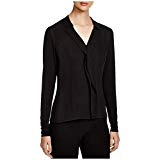

Product Title:  Elie Tahari Black Ruffled V-neck Long Sleeves Blouse Shirt, Black, X-Large
Euclidean Distance from input image: 6.8770432e-06
Amazon Url: www.amzon.com/dp/B0728DT431


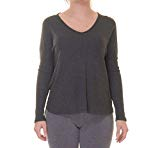

Product Title:  One Clothing Juniors' Thermal-Knit High-Low Tunic Top Size XL
Euclidean Distance from input image: 33.538757
Amazon Url: www.amzon.com/dp/B06XNQ49FN


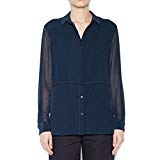

Product Title:  Brochu Walker Womens Vera Blouse Shadow Extra Small
Euclidean Distance from input image: 33.828888
Amazon Url: www.amzon.com/dp/B01MZ8SOVU


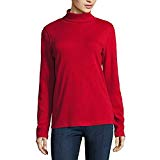

Product Title:  St. John's Bay Long Sleeve Turtleneck Size M Rumba Red
Euclidean Distance from input image: 34.683544
Amazon Url: www.amzon.com/dp/B06Y45K99H


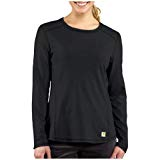

Product Title:  Women's Carhartt Force Long-sleeved Crewneck, TULIP PINK HTHR, SM
Euclidean Distance from input image: 35.188572
Amazon Url: www.amzon.com/dp/B00EALU0XW


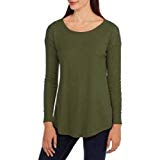

Product Title:  French Laundry Women's Ribbed Tunic with Lace Trim, Olive Camo, XL
Euclidean Distance from input image: 35.22221
Amazon Url: www.amzon.com/dp/B06XNJHPDS


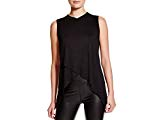

Product Title:  Benjamin Jay Women's Slider Cross Front Tank in Black Size Small
Euclidean Distance from input image: 35.279713
Amazon Url: www.amzon.com/dp/B071NBCMLT


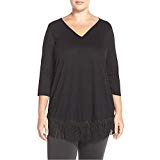

Product Title:  Junarose Plus Size V-Neck Fringe Top Black 2X
Euclidean Distance from input image: 35.29977
Amazon Url: www.amzon.com/dp/B00YJ28O8U


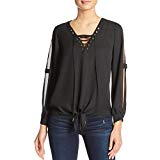

Product Title:  Landa by Dora Landa Womens Georgette Lace Up Blouse Black S
Euclidean Distance from input image: 35.305943
Amazon Url: www.amzon.com/dp/B0741T7Y2L


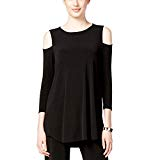

Product Title:  Alfani Cold-Shoulder Top, Black, Medium
Euclidean Distance from input image: 35.339775
Amazon Url: www.amzon.com/dp/B0741VGRZ7


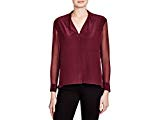

Product Title:  Charlie Jade Women's Long Sheer Sleeve Top Burgundy Size X-Small
Euclidean Distance from input image: 35.42785
Amazon Url: www.amzon.com/dp/B071HNYH6C


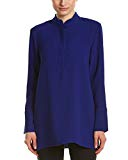

Product Title:  Josie Natori Womens Top, M, Blue
Euclidean Distance from input image: 35.483707
Amazon Url: www.amzon.com/dp/B01NBXRIH8


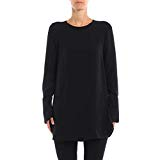

Product Title:  Max Mara Women's Alfio Silk Tunic Sz 8 Black
Euclidean Distance from input image: 35.48663
Amazon Url: www.amzon.com/dp/B0749RSMGN


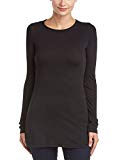

Product Title:  Bobi Womens Bobi Sharkbite Tunic Top, Xs, Black
Euclidean Distance from input image: 35.50697
Amazon Url: www.amzon.com/dp/B01M4NNXXZ


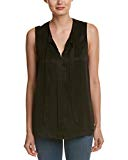

Product Title:  Splendid Womens Tie-Neck Blouse, L, Black
Euclidean Distance from input image: 35.560513
Amazon Url: www.amzon.com/dp/B0716F4X2L


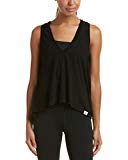

Product Title:  Vimmia Womens Vimmia Pacific Cowl Back Tank, Xl, Black
Euclidean Distance from input image: 35.861244
Amazon Url: www.amzon.com/dp/B0717997RX


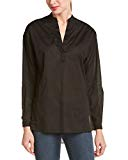

Product Title:  Rag & Bone Womens / Jean High-Low Tunic, Xxs, Black
Euclidean Distance from input image: 36.080498
Amazon Url: www.amzon.com/dp/B06XCZFCWM


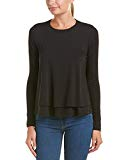

Product Title:  Susana Monaco Womens Susana Monoco Crew Neck Top, Xs, Black
Euclidean Distance from input image: 36.19855
Amazon Url: www.amzon.com/dp/B0753W3VML


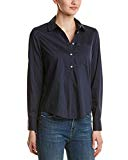

Product Title:  J Brand Womens Pinstripe Shirt, Xs, Blue
Euclidean Distance from input image: 36.33792
Amazon Url: www.amzon.com/dp/B06XYP1X1F


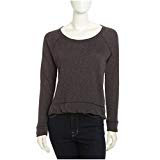

Product Title:  James Perse Vintage Raglan Top, Slate, 2 / Medium
Euclidean Distance from input image: 36.46025
Amazon Url: www.amzon.com/dp/B01NCOIN8Q


In [88]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('Data/16k_data_cnn_features.npy')
asins = np.load('Data/asin.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('Data/Pickle/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

cnn_euclidean=[]

from IPython.display import display, Image, SVG, Math, YouTubeVideo

#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)


In [ ]:
_End_